# Kernel for evaluating a single model with Cross Validation

## TODO :
* Less treatment
* More Features
* Faster embed loader
* Improve embed merging
* test different seeds

In [1]:
import re
import gc
import os
import time
import random
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
tqdm.pandas()

from nltk import word_tokenize
from collections import Counter
from sklearn.utils import shuffle
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import TweetTokenizer
from multiprocessing import Pool, cpu_count
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

import torch
import torch.nn as nn
import torch.utils.data

import psutil
import multiprocessing
import markovify as mk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.set_random_seed(seed)

In [3]:
seed = np.random.randint(10000)
seed

5583

In [4]:
seed_everything(seed)
begin = time.time()
sns.set_style('whitegrid')

In [5]:
with_features = True

In [6]:
mode = "kfold"
# mode = "multifit"

In [7]:
GLOVE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
PARAGRAM = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
FASTTEXT = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

# Text Data

## Loading

In [8]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


## Augmenting

In [9]:
augment_insincere_count = 0

In [10]:
class MarkovifyTextAugmentor(object):
    def __init__(self, docs, gen_max_len, filter_min_len=10):
        """
        Build Markov models from large corpora of text, and generating random sentences from that.
        """
        self.mk_text_model = mk.Text(docs)
        self.gen_max_len = gen_max_len
        self.filter_min_len = filter_min_len
    
    def genenerate(self, count):
        texts = []
        for _ in range(count):
            text = self.mk_text_model.make_short_sentence(self.gen_max_len)
            if text and len(text.split(' ')) > self.filter_min_len:
                texts.append(text)
        return texts

In [11]:
insincere_df = train_df[train_df['target'] == 1]
insincere_texts = insincere_df['question_text'].apply(" ".join)
median_length = int(insincere_texts.str.len().median())

mk_augmentor = MarkovifyTextAugmentor(insincere_texts, median_length, filter_min_len=6)

In [12]:
%%time
def gen_text_process(count):
    return mk_augmentor.genenerate(count)

num_cores = psutil.cpu_count()  # number of cores on your machine
pool = multiprocessing.Pool(processes=num_cores)

apply_results = []
process_counts = augment_insincere_count // num_cores
for _ in range(num_cores):
    apply_results.append(pool.apply_async(gen_text_process, (process_counts,)))

pool.close()
pool.join()

generated_texts = []
for res in apply_results:
    generated_texts.extend(res.get())

CPU times: user 4 ms, sys: 32 ms, total: 36 ms
Wall time: 163 ms


In [13]:
print('Generated {} insincere questions'.format(len(generated_texts)))

Generated 0 insincere questions


In [14]:
gen_df = pd.DataFrame({'question_text': generated_texts, 'target': [1] * len(generated_texts)})
gen_df.head()

,question_text,target


In [15]:
if augment_insincere_count > 0:
    train_df = pd.concat((train_df, gen_df), axis=0, sort=True)
    train_df = shuffle(train_df, random_state=seed)

## Features

### Toxic word ratio

In [16]:
toxic_words = ['4r5e', '5h1t', '5hit', 'a55', 'anal', 'anus', 'ar5e', 'arrse', 'arse', 'ass', 'ass-fucker', 'asses', 'assfucker', 'assfukka', 'asshole', 'assholes', 'asswhole', 'a_s_s', 'b!tch', 'b00bs', 'b17ch', 'b1tch', 'ballbag', 'balls', 'ballsack', 'bastard', 'beastial', 'beastiality', 'bellend', 'bestial', 'bestiality', 'bi+ch', 'biatch', 'bitch', 'bitcher', 'bitchers', 'bitches', 'bitchin', 'bitching', 'bloody', 'blow', 'job', 'blowjob', 'blowjobs', 'boiolas', 'bollock', 'bollok', 'boner', 'boob', 'boobs', 'booobs', 'boooobs', 'booooobs', 'booooooobs', 'breasts', 'buceta', 'bugger', 'bum', 'bunny', 'fucker', 'butt', 'butthole', 'buttmuch', 'buttplug', 'c0ck', 'c0cksucker', 'carpet', 'muncher', 'cawk', 'chink', 'cipa', 'cl1t', 'clit', 'clitoris', 'clits', 'cnut', 'cock', 'cock-sucker', 'cockface', 'cockhead', 'cockmunch', 'cockmuncher', 'cocks', 'cocksuck', 'cocksucked', 'cocksucker', 'cocksucking', 'cocksucks', 'cocksuka', 'cocksukka', 'cok', 'cokmuncher', 'coksucka', 'coon', 'cox', 'crap', 'cum', 'cummer', 'cumming', 'cums', 'cumshot', 'cunilingus', 'cunillingus', 'cunnilingus', 'cunt', 'cuntlick', 'cuntlicker', 'cuntlicking', 'cunts', 'cyalis', 'cyberfuc', 'cyberfuck', 'cyberfucked', 'cyberfucker', 'cyberfuckers', 'cyberfucking', 'd1ck', 'damn', 'dick', 'dickhead', 'dildo', 'dildos', 'dink', 'dinks', 'dirsa', 'dlck', 'dog-fucker', 'doggin', 'dogging', 'donkeyribber', 'doosh', 'duche', 'dyke', 'ejaculate', 'ejaculated', 'ejaculates', 'ejaculating', 'ejaculatings', 'ejaculation', 'ejakulate', 'f', 'u', 'c', 'k', 'f', 'u', 'c', 'k', 'e', 'r', 'f4nny', 'fag', 'fagging', 'faggitt', 'faggot', 'faggs', 'fagot', 'fagots', 'fags', 'fanny', 'fannyflaps', 'fannyfucker', 'fanyy', 'fatass', 'fcuk', 'fcuker', 'fcuking', 'feck', 'fecker', 'felching', 'fellate', 'fellatio', 'fingerfuck', 'fingerfucked', 'fingerfucker', 'fingerfuckers', 'fingerfucking', 'fingerfucks', 'fistfuck', 'fistfucked', 'fistfucker', 'fistfuckers', 'fistfucking', 'fistfuckings', 'fistfucks', 'flange', 'fook', 'fooker', 'fuck', 'fucka', 'fucked', 'fucker', 'fuckers', 'fuckhead', 'fuckheads', 'fuckin', 'fucking', 'fuckings', 'fuckingshitmotherfucker', 'fuckme', 'fucks', 'fuckwhit', 'fuckwit', 'fudge', 'packer', 'fudgepacker', 'fuk', 'fuker', 'fukker', 'fukkin', 'fuks', 'fukwhit', 'fukwit', 'fux', 'fux0r', 'f_u_c_k', 'gangbang', 'gangbanged', 'gangbangs', 'gaylord', 'gaysex', 'goatse', 'God', 'god-dam', 'god-damned', 'goddamn', 'goddamned', 'hardcoresex', 'hell', 'heshe', 'hoar', 'hoare', 'hoer', 'homo', 'hore', 'horniest', 'horny', 'hotsex', 'jack-off', 'jackoff', 'jap', 'jerk-off', 'jism', 'jiz', 'jizm', 'jizz', 'kawk', 'knob', 'knobead', 'knobed', 'knobend', 'knobhead', 'knobjocky', 'knobjokey', 'kock', 'kondum', 'kondums', 'kum', 'kummer', 'kumming', 'kums', 'kunilingus', 'l3i+ch', 'l3itch', 'labia', 'lmfao', 'lust', 'lusting', 'm0f0', 'm0fo', 'm45terbate', 'ma5terb8', 'ma5terbate', 'masochist', 'master-bate', 'masterb8', 'masterbat*', 'masterbat3', 'masterbate', 'masterbation', 'masterbations', 'masturbate', 'mo-fo', 'mof0', 'mofo', 'mothafuck', 'mothafucka', 'mothafuckas', 'mothafuckaz', 'mothafucked', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking', 'mothafuckings', 'mothafucks', 'mother', 'fucker', 'motherfuck', 'motherfucked', 'motherfucker', 'motherfuckers', 'motherfuckin', 'motherfucking', 'motherfuckings', 'motherfuckka', 'motherfucks', 'muff', 'mutha', 'muthafecker', 'muthafuckker', 'muther', 'mutherfucker', 'n1gga', 'n1gger', 'nazi', 'nigg3r', 'nigg4h', 'nigga', 'niggah', 'niggas', 'niggaz', 'nigger', 'niggers', 'nob', 'nob', 'jokey', 'nobhead', 'nobjocky', 'nobjokey', 'numbnuts', 'nutsack', 'orgasim', 'orgasims', 'orgasm', 'orgasms', 'p0rn', 'pawn', 'pecker', 'penis', 'penisfucker', 'phonesex', 'phuck', 'phuk', 'phuked', 'phuking', 'phukked', 'phukking', 'phuks', 'phuq', 'pigfucker', 'pimpis', 'piss', 'pissed', 'pisser', 'pissers', 'pisses', 'pissflaps', 'pissin', 'pissing', 'pissoff', 'poop', 'porn', 'porno', 'pornography', 'pornos', 'prick', 'pricks', 'pron', 'pube', 'pusse', 'pussi', 'pussies', 'pussy', 'pussys', 'rectum', 'retard', 'rimjaw', 'rimming', 's', 'hit', 's.o.b.', 'sadist', 'schlong', 'screwing', 'scroat', 'scrote', 'scrotum', 'semen', 'sex', 'sh!+', 'sh!t', 'sh1t', 'shag', 'shagger', 'shaggin', 'shagging', 'shemale', 'shi+', 'shit', 'shitdick', 'shite', 'shited', 'shitey', 'shitfuck', 'shitfull', 'shithead', 'shiting', 'shitings', 'shits', 'shitted', 'shitter', 'shitters', 'shitting', 'shittings', 'shitty', 'skank', 'slut', 'sluts', 'smegma', 'smut', 'snatch', 'son-of-a-bitch', 'spac', 'spunk', 's_h_i_t', 't1tt1e5', 't1tties', 'teets', 'teez', 'testical', 'testicle', 'tit', 'titfuck', 'tits', 'titt', 'tittie5', 'tittiefucker', 'titties', 'tittyfuck', 'tittywank', 'titwank', 'tosser', 'turd', 'tw4t', 'twat', 'twathead', 'twatty', 'twunt', 'twunter', 'v14gra', 'v1gra', 'vagina', 'viagra', 'vulva', 'w00se', 'wang', 'wank', 'wanker', 'wanky', 'whoar', 'whore', 'willies', 'willy', 'xrated', 'xxx']

In [17]:
def toxic_words_ratio(text, toxic_words=toxic_words):
    count = 0
    text = word_tokenize(text)
    for word in text:
        count += int(word.lower() in toxic_words)
    return count / len(text)

### Frequency Ratio

In [18]:
def build_vocab(texts):
    vocab = {}
    for sentence in texts:
        for word in sentence.split(' '):
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [19]:
%%time
word_count = build_vocab(list(train_df['question_text']) + list(test_df['question_text']))

CPU times: user 5.74 s, sys: 100 ms, total: 5.84 s
Wall time: 5.85 s


In [20]:
def freq_count(text):
    text = text.split(" ")
    all_count = 0
    for word in text:
        all_count += word_count[word]
    return len(text) / all_count

### Making all features

In [21]:
def make_features(df):    
    df['total_length'] = df['question_text'].apply(len)
    df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['toxic_ratio'] = df['question_text'].apply(toxic_words_ratio)
    df['word_freq'] = df['question_text'].apply(freq_count)

In [22]:
%%time
if with_features:
    make_features(train_df)
    make_features(test_df)

CPU times: user 7min 13s, sys: 728 ms, total: 7min 14s
Wall time: 7min 14s


## Preprocessing
- Treating apostrophes
- Substituting with dic (contractions, misspels, some punctuation)
- Removing 's and lone '
- Lowering the first letter of sentences
- Cleaning remaining special characters
- Replacing digits with #s


### Data

In [23]:
# All appearing special characters
useful_punct = ['_', '☹', '＞', '½', '△', '¿', '¼', '∆', '≥', '⇒', '¬', '∨', '＾', 'µ', '?', '!', '.', ',', '"', '#', '$', '%', '\\', "'", '(', ')', '*', '+', '-', '/', ':', ';', '<', '=', '>', '@', '[', ']', '^', '{', '|', '}', '~', '’', '′', '‘', '°', '→', '£', 'ø', '´', '↑', 'θ', '±', '≤', '≠', '...', '⟨', '⟩', '∖', 'ⁿ', '⅔', '❤', '✌', '✅', '✓', '∘', '¨', '″', 'ύ', 'ኤ', 'ል', 'ሮ', 'ኢ', 'የ', 'ኝ', 'ን', 'አ', 'ሁ', '≅', 'ϕ', '‑', '￼', 'ֿ', 'か', 'く', 'れ', '－', 'ș', 'ן', '∪', 'φ', 'ψ', '⊨', 'β', '∠', '«', '»', 'ம', '≈', '⁰', '⁷', '،', '＝', '（', '）', 'ə', 'ɑ', 'ː', '¹', '⅓', 'ř', '《', '》', 'ρ', '∅', '&', '·', '©', '¥', '：', '⋅', '↓', '、', '│', '，', '・', '•', '®', '`', '€', '™', '›', '♥', '←', '×', '§', 'Â', '█', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '░', '¶', '▾', '═', '¦', '║', '―', '▓', '—', '‹', '─', '▒', '⊕', '▼', '▪', '†', '■', '▀', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '∞', '∙', '♪', '╩', '╚', '³', '╦', '╣', '╔', '╗', '▬', 'ï', 'Ø', '‡', '√']
useless_punct = ['च', '不', 'ঢ়', '平', 'ᠠ', '錯', '判', '∙', '言', 'ς', 'ل', '្', 'ジ', 'あ', '得', '水', 'ь', '◦', '创', '康', '華', 'ḵ', '☺', '支', '就', '„', '」', '어', '谈', '陈', '团', '腻', '权', '年', '业', 'マ', 'य', 'ا', '売', '甲', '拼', '˂', 'ὤ', '贯', '亚', 'ि', '放', 'ʻ', 'ទ', 'ʖ', '點', '્', '発', '青', '能', '木', 'д', '微', '藤', '̃', '僕', '妒', '͜', 'ន', 'ध', '이', '希', '特', 'ड', '¢', '滢', 'ส', '나', '女', 'క', '没', '什', 'з', '天', '南', 'ʿ', 'ค', 'も', '凰', '步', '籍', '西', 'ำ', '−', 'л', 'ڤ', 'ៃ', '號', 'ص', 'स', '®', 'ʋ', '批', 'រ', '치', '谢', '生', '道', '═', '下', '俄', 'ɖ', '觀', 'வ', '—', 'ی', '您', '♥', '一', 'や', '⊆', 'ʌ', '語', 'ี', '兴', '惶', '瀛', '狐', '⁴', 'प', '臣', 'ద', '―', 'ì', 'ऌ', 'ీ', '自', '信', '健', '受', 'ɨ', '시', 'י', 'ছ', '嬛', '湾', '吃', 'ち', 'ड़', '反', '红', '有', '配', 'ে', 'ឯ', '宮', 'つ', 'μ', '記', '口', '℅ι', 'ो', '狸', '奇', 'о', 'ट', '聖', '蘭', '読', 'ū', '標', '要', 'ត', '识', 'で', '汤', 'ま', 'ʀ', '局', 'リ', '्', 'ไ', '呢', '工', 'ल', '沒', 'τ', 'ិ', 'ö', 'せ', '你', 'ん', 'ュ', '枚', '部', '大', '罗', 'হ', 'て', '表', '报', '攻', 'ĺ', 'ฉ', '∩', '宝', '对', '字', '文', '这', '∑', '髪', 'り', '่', '능', '罢', '내', '阻', '为', '菲', 'ي', 'न', 'ί', 'ɦ', '開', '†', '茹', '做', '東', 'ত', 'に', 'ت', '晓', '키', '悲', 'સ', '好', '›', '上', '存', '없', '하', '知', 'ធ', '斯', ' ', '授', 'ł', '傳', '兰', '封', 'ோ', 'و', 'х', 'だ', '人', '太', '品', '毒', 'ᡳ', '血', '席', '剔', 'п', '蛋', '王', '那', '梦', 'ី', '彩', '甄', 'и', '柏', 'ਨ', '和', '坊', '⌚', '广', '依', '∫', 'į', '故', 'ś', 'ऊ', '几', '日', 'ک', '音', '×', '”', '▾', 'ʊ', 'ज', 'ด', 'ठ', 'उ', 'る', '清', 'ग', 'ط', 'δ', 'ʏ', '官', '∛', '়', '้', '男', '骂', '复', '∂', 'ー', '过', 'য', '以', '短', '翻', 'র', '教', '儀', 'ɛ', '‹', 'へ', '¾', '合', '学', 'ٌ', '학', '挑', 'ष', '比', '体', 'م', 'س', 'អ', 'ת', '訓', '∀', '迎', 'វ', 'ɔ', '٨', '▒', '化', 'చ', '‛', 'প', 'º', 'น', '업', '说', 'ご', '¸', '₹', '儿', '︠', '게', '骨', 'ท', 'ऋ', 'ホ', '茶', '는', 'જ', 'ุ', '羡', '節', 'ਮ', 'উ', '番', 'ড়', '讲', 'ㅜ', '등', '伟', 'จ', '我', 'ล', 'す', 'い', 'ញ', '看', 'ċ', '∧', 'भ', 'ઘ', 'ั', 'ម', '街', 'ય', '还', '鰹', 'ខ', 'ు', '訊', 'म', 'ю', '復', '杨', 'ق', 'त', '金', '味', 'ব', '风', '意', '몇', '佬', '爾', '精', '¶', 'ం', '乱', 'χ', '교', 'ה', '始', 'ᠰ', '了', '个', '克', '্', 'ห', '已', 'ʃ', 'わ', '新', '译', '︡', '本', 'ง', 'б', 'け', 'ి', '明', '¯', '過', 'ك', 'ῥ', 'ف', 'ß', '서', '进', 'ដ', '样', '乐', '寧', '€', 'ณ', 'ル', '乡', '子', 'ﬁ', 'ج', '慕', '–', 'ᡵ', 'Ø', '͡', '제', 'Ω', 'ប', '絕', '눈', 'फ', 'ম', 'గ', '他', 'α', 'ξ', '§', 'ஜ', '黎', 'ね', '복', 'π', 'ú', '鸡', '话', '会', 'ক', '八', '之', '북', 'ن', '¦', '가', 'ו', '恋', '地', 'ῆ', '許', '产', 'ॡ', 'ش', '़', '野', 'ή', 'ɒ', '啧', 'យ', '᠌', 'ᠨ', 'ب', '皎', '老', '公', '☆', 'व', 'ি', 'ល', 'ر', 'គ', '행', 'ង', 'ο', '让', 'ំ', 'λ', 'خ', 'ἰ', '家', 'ট', 'ब', '理', '是', 'め', 'र', '√', '기', 'ν', '玉', '한', '入', 'ד', '别', 'د', 'ะ', '电', 'ા', '♫', 'ع', 'ં', '堵', '嫉', '伊', 'う', '千', '관', '篇', 'क', '非', '荣', '粵', '瑜', '英', '를', '美', '条', '`', '宋', '←', '수', '後', '•', '³', 'ी', '고', '肉', '℃', 'し', '漢', '싱', 'ϵ', '送', 'ه', '落', 'న', 'ក', 'க', 'ℇ', 'た', 'ះ', '中', '射', '♪', '符', 'ឃ', '谷', '分', '酱', 'び', 'থ', 'ة', 'г', 'σ', 'と', '楚', '胡', '饭', 'み', '禮', '主', '直', '÷', '夢', 'ɾ', 'চ', '⃗', '統', '高', '顺', '据', 'ら', '頭', 'よ', '最', 'ా', 'ੁ', '亲', 'ស', '花', '≡', '眼', '病', '…', 'の', '發', 'ா', '汝', '★', '氏', 'ร', '景', 'ᡠ', '读', '件', '仲', 'শ', 'お', 'っ', 'پ', 'ᡤ', 'ч', '♭', '悠', 'ं', '六', '也', 'ռ', 'য়', '恐', 'ह', '可', '啊', '莫', '书', '总', 'ষ', 'ք', '̂', '간', 'な', '此', '愛', 'ర', 'ใ', '陳', 'Ἀ', 'ण', '望', 'द', '请', '油', '露', '니', 'ş', '宗', 'ʍ', '鳳', 'अ', '邋', '的', 'ព', '火', 'ा', 'ก', '約', 'ட', '章', '長', '商', '台', '勢', 'さ', '국', 'Î', '簡', 'ई', '∈', 'ṭ', '經', '族', 'ु', '孫', '身', '坑', 'স', '么', 'ε', '失', '殺', 'ž', 'ર', 'が', '手', 'ា', '心', 'ਾ', '로', '朝', '们', '黒', '欢', '早', '️', 'া', 'आ', 'ɸ', '常', '快', '民', 'ﷺ', 'ូ', '遢', 'η', '国', '无', '江', 'ॠ', '「', 'ন', '™', 'ើ', 'ζ', '紫', 'ె', 'я', '“', '♨', '國', 'े', 'อ', '∞']

# Mapping special letters
letter_mapping = {'\u200b':' ', 'ũ': "u", 'ẽ': 'e', 'é': "e", 'á': "a", 'ķ': 'k', 'ï': 'i', 'Ź': 'Z', 'Ż': 'Z', 'Š': 'S', 'Π': ' pi ', 'Ö': 'O', 'É': 'E', 'Ñ': 'N', 'Ž': 'Z', 'ệ': 'e', '²': '2', 'Å': 'A', 'Ā': 'A', 'ế': 'e', 'ễ': 'e', 'ộ': 'o', '⧼': '<', '⧽': '>', 'Ü': 'U', 'Δ': 'delta', 'ợ': 'o', 'İ': 'I', 'Я': 'R', 'О': 'O', 'Č': 'C', 'П': 'pi', 'В': 'B', 'Φ': 'phi', 'ỵ': 'y', 'օ': 'o', 'Ľ': 'L', 'ả': 'a', 'Γ': 'theta', 'Ó': 'O', 'Í': 'I', 'ấ': 'a', 'ụ': 'u', 'Ō': 'O', 'Ο': 'O', 'Σ': 'sigma', 'Â': 'A', 'Ã': 'A', 'ᗯ': 'w', 'ᕼ': "h", "ᗩ": "a", "ᖇ": "r", "ᗯ": "w", "O": "o", "ᗰ": "m", "ᑎ": "n", "ᐯ": "v", "н": "h", "м": "m", "o": "o", "т": "t", "в": "b", "υ": "u",  "ι": "i","н": "h", "č": "c", "š": "s", "ḥ": "h", "ā": "a", "ī": "i", "à": "a", "ý": "y", "ò": "o", "è": "e", "ù": "u", "â": "a", "ğ": "g", "ó": "o", "ê": "e", "ạ": "a", "ü": "u", "ä": "a", "í": "i", "ō": "o", "ñ": "n", "ç": "c", "ã": "a", "ć": "c", "ô": "o", "с": "c", "ě": "e", "æ": "ae", "î": "i", "ő": "o", "å": "a", "Ä": "A", }

In [24]:
rare_words_mapping = {' s.p ': ' ', ' S.P ': ' ', 'U.s.p': '', 'U.S.A.': 'USA', 'u.s.a.': 'USA', 'U.S.A': 'USA','u.s.a': 'USA', 'U.S.': 'USA', 'u.s.': 'USA', ' U.S ': ' USA ', ' u.s ': ' USA ', 'U.s.': 'USA', ' U.s ': 'USA', ' u.S ': ' USA ', 'fu.k': 'fuck', 'U.K.': 'UK', ' u.k ': ' UK ', ' don t ': ' do not ', 'bacteries': 'batteries', ' yr old ': ' years old ', 'Ph.D': 'PhD', 'cau.sing': 'causing', 'Kim Jong-Un': 'The president of North Korea', 'savegely': 'savagely', 'Ra apist': 'Rapist', '2fifth': 'twenty fifth', '2third': 'twenty third', '2nineth': 'twenty nineth', '2fourth': 'twenty fourth', '#metoo': 'MeToo', 'Trumpcare': 'Trump health care system', '4fifth': 'forty fifth', 'Remainers': 'remainder', 'Terroristan': 'terrorist', 'antibrahmin': 'anti brahmin', 'fuckboys': 'fuckboy', 'Fuckboys': 'fuckboy', 'Fuckboy': 'fuckboy', 'fuckgirls': 'fuck girls', 'fuckgirl': 'fuck girl', 'Trumpsters': 'Trump supporters', '4sixth': 'forty sixth', 'culturr': 'culture', 'weatern': 'western', '4fourth': 'forty fourth', 'emiratis': 'emirates', 'trumpers': 'Trumpster', 'indans': 'indians', 'mastuburate': 'masturbate', 'f**k': 'fuck', 'F**k': 'fuck', 'F**K': 'fuck', ' u r ': ' you are ', ' u ': ' you ', '操你妈': 'fuck your mother', 'e.g.': 'for example', 'i.e.': 'in other words', '...': '.', 'et.al': 'elsewhere', 'anti-Semitic': 'anti-semitic', 'f***': 'fuck', 'f**': 'fuc', 'F***': 'fuck', 'F**': 'fuc', 'a****': 'assho', 'a**': 'ass', 'h***': 'hole', 'A****': 'assho', 'A**': 'ass', 'H***': 'hole', 's***': 'shit', 's**': 'shi', 'S***': 'shit', 'S**': 'shi', 'Sh**': 'shit', 'p****': 'pussy', 'p*ssy': 'pussy', 'P****': 'pussy', 'p***': 'porn', 'p*rn': 'porn', 'P***': 'porn', 'st*up*id': 'stupid', 'd***': 'dick', 'di**': 'dick', 'h*ck': 'hack', 'b*tch': 'bitch', 'bi*ch': 'bitch', 'bit*h': 'bitch', 'bitc*': 'bitch', 'b****': 'bitch', 'b***': 'bitc', 'b**': 'bit', 'b*ll': 'bull'}

In [25]:
#Translations, probably too long to use.
words_to_english_map = {'隶书': 'Lishu', 'तपस्': 'Tapse', 'ให้': 'give', '宗教官': 'Religious officer', '没有神一样的对手': 'No god-like opponent', 'יהודיות': 'Jewish women', '我明明是中国人': 'I am obviously Chinese.', 'お早う': 'Good morning', 'मेरे': 'my', 'পরীক্ষা': 'Test', 'נעכטן': 'Yesterday', '中华民国': 'Republic of China', 'तकनीकी': 'Technical', 'यहाँ': 'here', '奇兵隊': 'Qibing', 'かﾟ': 'Or', '知识分子': 'Intellectuals', 'ごめなさい': "I'm sorry", '하기를': 'To', 'गाढवाचे': 'Donkey', 'इबादत': 'Worship', '千金': 'Thousand gold', 'ельзи': 'elzhi', '低端人口': 'Low-end population', '맛저': 'Mazur', 'दानि': 'Danias', 'юродство': 'foolishness', 'τον': 'him', '素质': 'Quality', '王晓菲': 'Wang Xiaofei', 'माहेर': 'Maher', 'لمصارى': 'For my advice', '送客！': 'see a visitor out!', '然而': 'however', 'जिग्यासा': 'Jigyaasa', '都市': 'city', 'ஜோடி': 'Pair', 'لاني': 'See', 'пельмени': 'dumplings', '请不要误会': "Please don't misunderstand", 'люис': 'Lewis', '不送！': 'Do not send!', 'के': 'Of', 'मस्का': 'Mascara', 'вoyѕ': 'voyce', 'बुन्ना': 'Bunna', '战略支援部队': 'Strategic support force', '平埔族': 'Pingpu', 'فهمت؟': 'I see?', 'कयामत': 'Apocalypse', 'ức': 'memory', 'ᗰeᑎ': 'ᗰe ᑎ', 'सेकना': 'Sexting', 'धकेलना': 'Shove', 'পারি': 'We can', 'مقام': 'Official', 'बेसति': 'Baseless', '歪果仁研究协会': 'Hazelnut Research Association', '短信': 'SMS', 'всегда': 'is always', '修身': 'Slim fit', 'إنَّ': 'that', '不是民国': 'Not the Republic of China', '写的好': 'Written well', 'õhtupoolik': 'afternoon', 'तालीन': 'Training', 'और': 'And', 'щит': 'shield', 'ᗩtteᑎtiᐯe': 'ᗩtte ᑎ ti ᐯ e', 'اسکوپیه': 'Script', 'çomar': 'fido', '和製英語': 'Japanglish', '吊着命': 'Hanging', 'много': 'much', 'समुराय': 'Samurai', 'भटकना': 'Wander', 'مقاومة': 'resistance', '싱관없어': 'I have no one.', '修身養性': 'Self-cultivation', 'मटका': 'pot', 'θιοψʼ': 'thiós', 'ㅎㅎㅎㅎ': 'Hehe', 'تساوى': 'Equal', 'बाट': 'From', '不地道啊。': 'Not authentic.', 'контакт': 'contact', '이런것도': 'This', 'तै': 'The', 'मेल': 'similarity', 'álvarez': 'Alvarez', 'नुक्स': 'Damage', '口訣': 'Mouth', 'масло': 'butter', 'परम्परा': 'Tradition', '学会': 'learn', 'کردن': 'Make up', 'öd': 'bile', 'टशन': 'Tashan', 'つらやましす': 'I am cheating', 'чего': 'what', '为什么总有人能在shoplex里免费获取iphone等重金商品？': 'Why do people always get free access to iphone and other heavy commodities in shoplex?', 'श्री': 'Mr', 'प्रेषक': 'Sender', 'خواندن': 'Read', 'बदलेंगे': 'Will change', 'बीएड': 'Breed', 'अदा': 'Paid', 'फैलाना': 'spread', 'ബുദ്ധിമാനായ': 'Intelligent', '谢谢六佬': 'Thank you, Liu Wei', 'উপস্থাপন': 'Present', 'بكلها': 'All of them', 'जाए': 'Go', '无可挑剔': 'Impeccable', 'आना': 'come', '太阴': 'lunar', 'القط': 'The cat', '있네': 'It is.', 'कर्म': 'Karma', 'आड़': 'Shroud', 'įit': 'IIT', 'जशने': 'Jashnay', 'से': 'From', 'åkesson': 'Åkesson', '乳名': 'Milk name', '我看起来像韩国人吗': 'Do I look like a Korean?', 'тнan': 'tn', 'العظام': 'Bones', '暹罗': 'Siam', '小肥羊鍋店': 'Little fat sheep pot shop', 'করেন': 'Do it', 'हरामी': 'bastard', 'डाले': 'Cast', 'استراحة': 'Break', '射道': 'Shooting', 'επιστήμη': 'science', 'χράομαι': "I'm glad", '脚踏车': 'bicycle', 'हिलना': 'To move', 'đa': 'multi', '標點符號': 'Punctuation', 'मैं': 'I', '不能化生水谷精微': "Can't transform the water valley", 'निवाला': 'Boar', 'दर्शनाभिलाषी': 'Spectacular', 'বাছাই': 'Picking', 'どくぜんてき': 'Dokedari', 'पीवें।': 'Pieve.', 'ʻoumuamua': 'Priority', 'में': 'In', 'चलाऊ': 'Run', 'निपटाना': 'To settle', 'ごはん': 'rice', 'चार्ज': 'Charge', 'शिथिल': 'Loosely', 'ястребиная': 'yastrebina', 'ложись': 'lie down', '李银河': 'Li Yinhe', 'へも': 'Also', 'हुलिया': 'Hulia', 'ऊब': 'Bored', 'छाछ': 'Buttermilk', 'عن': 'About', 'नहीं': 'No', 'जीव': 'creatures', 'जेहाद': 'Jehad', 'νερό': 'water', '열여섯': 'sixteen', 'मार': 'Kill', '早就': 'Long ago', '《齐天大圣》for': '"Qi Tian Da Sheng" for', 'الجنس': 'Sex', 'مع': 'With', 'रंगरलियाँ': 'Color palettes', 'जोल': 'Jol', 'बुद्धी': 'Intelligence', '罗思成': 'Luo Sicheng', '独善的': 'Self-righteousness', 'धर्मः': 'Religion', '中国大陆的同胞们': 'Chinese compatriots', '愛してない': 'I do not love you', '日本語が上手ですね': 'Japanese is good', 'ओठ': 'Lips', '如果你希望表達你的觀點': 'If you want to express your opinion', 'देशवाशी': 'Countryman', 'καί': 'and', '阮铭': 'Yu Ming', '跑步跑': 'Running', 'हो': 'Ho', '「褒められる」': '"Praised"', 'నా': 'My', '\x10new': '?new', 'ゆいがどくそん': 'A graduate student', '白语': 'White language', 'वह': 'She', '白い巨塔': 'White big tower', '로리이고': 'Lori.', 'परि': 'Circumcision', 'æj': 'Aw', 'انضيع': 'Lost', '平民苗字必称義務令': 'Civilian Miaozi must be called an obligation', 'ਸਿੰਘ': 'Singh', 'уже': 'already', 'đầu': 'head', '雨热同期': 'Rain and heat', 'घुलना': 'Dissolve', 'мис': 'Miss', 'て下さいませんか': 'Could it be?', '猫头鹰': 'owl', 'चढ़': 'Climbing', '漢音': 'Hanyin', 'यही': 'This only', '只有猪一样的队友': 'Only pig-like teammates', 'übersoldaten': 'about soldiers', 'αθ': 'Ath', 'ουδεις': 'no', '党国合一': 'Party and country', 'रेड': 'Red', 'ढोलना': 'Drift', 'शाक': 'Shake', '같이': 'together', '攻克': 'capture', 'özalan': 'exclusive', 'काम': 'work', 'चाहना': 'Wish', '坚持一个中国原则': 'Adhere to the one-China principle', '배우고': 'Learn', '柴棍': 'Firewood stick', 'उसे': 'To him', 'на': 'on', '無手': 'No hands', 'čvrsnica': 'Čvrsnica', 'ज़ार': 'Tsar', 'ˆo': 'O', '後宮甄嬛傳': 'Harem of the harem', '意音文字': 'Sound character', 'बहारा': 'Bahara', 'てみる': 'Try', '老铁': 'Old iron', '野比のび太': 'Nobita Nobita', 'याद': 'remember', 'پیشی': 'Surpass', 'توقعك': 'Your expectation', 'はたち': 'Slender', 'فزت': 'I won', '伊藤': 'Ito', 'कलेजे': 'Liver', 'αγεν': 'ruin', 'ìmprovement': 'Improvement', 'では': 'Then.', 'பார்ப்பது': 'Viewing', '只留清气满乾坤': 'Only stay clear and full of energy', '이정도쯤': 'About this', 'すてん': 'Sponge', 'ما': 'What', '海南人の日本': "Hainan people's Japan", '小鹿乱撞': 'very excited', 'ῥωμαῖοι': 'ῥomaşii', 'वारी': 'Vary', 'भोज': 'Feast', '陈庚': 'Chen Geng', 'कट्टरवादि': 'Fanatic', '凌霸': 'Lingba', 'पार': 'The cross', 'कुचलना': 'To crush', 'रहा': 'Stayed', 'हम': 'We', 'бойся': 'be afraid', '大刀': 'Large sword', 'ন্ন': 'Done', '汽车': 'car', 'কে': 'Who', 'الکعبه': 'Alkaebe', '网络安全法': 'Cybersecurity law', 'नेपाली': 'Nepali', 'পদের': 'Position', '\x92t': '??t', 'रास': 'Ras', 'لكل': 'for every', 'शूद्राणां': 'Shudran', '此问题只是针对外国友人的一次统计': 'This question is only a statistic for foreign friends.', 'ឃើញឯកសារអំពីប្រវត្តិស្ត្រនៃប្រាសាទអង្គរវត្ត': 'See the history of Angkor Wat', 'спасибо': 'thank', 'رب': 'God', 'वजूद': 'Non existent', 'पकड़': 'Hold', 'बरहा': 'Baraha', '雾草': 'Fog grass', 'мощный': 'powerful', 'বৃদ্ধাশ্রম': 'Old age', 'आई': 'Mother', 'खड़ी': 'Steep', '\x1aaùõ\x8d': '? aùõ ??', 'āto': 'standard', '在冰箱裡': 'in the refrigerator', 'đời': 'life', 'लड़का': 'The boy', 'τὸ': 'the', 'مدرسان': 'Instructors', 'பறை': 'Drum', 'índia': 'India', 'दिया': 'Gave', '小篆': 'Xiao Yan', '唐樂': 'Tang Le', '米国': 'USA', '文言文': 'Classical Chinese', 'उवाच': 'Uwach', 'هدف': 'Target', 'घेरा': 'Cordon', 'झूम': 'Zoom', 'εσσα': 'all the same', '和製漢語': 'And making Chinese', 'ऐलोपैथिक': 'Allopathic', 'создала': 'has created', 'إدمان': 'addiction', '游泳游': 'Swimming tour', '狮子头': 'Lion head', 'दिये': 'Given', 'पास': 'near', 'εντjα': 'in', 'まする': 'To worship', 'हाल': 'condition', '짱깨': 'Chin', 'জল': 'Water', 'चीज': 'thing', 'îmwe': 'one', '胡江南': 'Hu Jiangnan', 'तमाम': 'All', 'कट्टर': 'Hardcore', '魔法师': 'Magician', 'బుూ\u200c': 'Buu', 'चनचल': 'Chanchal', 'सीधा': 'Straightforward', '不要人夸颜色好': "Don't exaggerate the color", 'हिमालय': 'Himalaya', 'सिंह': 'Lion', 'خراميشو': 'Wastewater', 'мoѕт': 'the moment', 'কোথায়': 'Where?', 'نصف': 'Half', 'رائع': 'Wonderful', 'добрый': 'kind', 'ज़र्रा': 'Zarra', 'يعقوب': 'Yacoub', 'सम्झौता': 'Agreement', 'ān': 'yes', '했다': 'did', 'ἀριστοκράτης': 'aristocrat', 'çan': 'Bell', '太阳': 'sun', 'सर': 'head', 'गुरु': 'Master', '嘉定': 'Jiading', '故乡': 'home', '安倍晋三': 'Shinzo Abe', 'मच्छर': 'Mosquito', 'सभी': 'All', '成語': 'idiom', '唯我独尊': 'Only me', 'นะค่ะ': 'Yes', 'นั่นคุณกำลังทำอะไร': 'What are you doing', 'ın': 's', 'الشامبيونزليج': 'Shamballons', '抗日神剧': 'Anti-Japanese drama', '小妹': 'Little sister', 'çok': 'very', 'लोड': 'Load', 'साहित्यिक': 'Literary', 'लाल।': 'Red.', 'فى': 'in a', '絕不放過一人」之勢': 'Never let go of one person', '国家主席': 'National president', '异议': 'objection', 'अनुस्वार': 'Anuswasar', 'តើបងប្អូនមានមធ្យបាយអ្វីខ្លះដើម្បីរក': 'What are some ways to find out', '允≱ၑご搢': '≱ ≱ ≱ 搢', '黒髪': 'Black hair', '自戳双目': 'Self-poke binocular', 'βροχέως': 'rainy', 'ని': 'The', '一带一路': 'Belt and Road', 'śliwińska': 'Śliwińska', 'κατὰ': 'against', '打古人名': 'Hit the ancient name', 'குறை': 'Low', 'üjin': 'Uji', 'öppning': 'opening', 'अन्जल': 'Anjal', '이와': 'And', 'आविष्कार': 'Invention', 'غنج': 'Gnostic', 'рассвет': 'dawn', 'होना': 'Happen', 'বাড়ি': 'Home', '入定': 'Enter', 'भेड़': 'The sheep', 'देगा': 'Will give', 'ब्रह्मा': 'Brahma', 'बीन': 'Bean', 'χράω': "I'm glad", 'तीन': 'three', 'ضرار': 'Drar', 'विराजमान': 'Seated', 'सैलाब': 'Salab', 'συνηθείας': 'communication', '구경하고': 'To see', 'चुल्ल': 'Chool', '红宝书': 'Red book', '羡慕和嫉妒是不一样的。': 'Envy and jealousy are not the same.', 'मेरा': 'my', 'कलटि': 'Katiti', 'हिमाती': 'Himalayan', 'ಸಾಧು': 'Sadhu', 'عطيتها': 'Her gift', 'छान': 'Nice', 'เกาหลี': 'Korea', 'íntruments': 'instruments', 'يتحمل': 'Bear', 'रुस्तम': 'Rustam', 'बरात': 'Baraat', 'रंग': 'colour', '나이': 'age', 'פרפר': 'butterfly', '老乡': 'Hometown', '謝謝': 'Thank you', 'í‰lbƒ': '‰ in lbƒ', 'हरजाई': 'Harjai', 'পেতে': 'Get to', '「勉強': '"study', 'रड़कना': 'To cry', '清真诊所': 'Halal clinic', 'أفضل': 'Best', 'استطيع': 'I can', 'नाकतोडा': 'Nag', 'बड़ि': 'Elder', 'वैद्य': 'Vaidya', 'أنَّ': 'that', 'いたロリィis': 'There was Lory', 'ìn': 'print', '本人堅持一個中國的原則': 'I adhere to the one-China principle', 'океан': 'ocean', 'बाद': 'after', '禮儀': 'etiquette', 'सिषेविरे': 'Sisavir', 'अमृत': 'Honeydew', 'بدو': 'run', 'ὅς': 'that is', 'छोटा': 'small', 'स्वभावप्रभवैर्गुणै': 'Nature is bad', 'ענג': 'Tight', 'שלמה': 'Complete', 'डोरे': 'Dore', '我害怕得毛骨悚然': 'I am afraid of creeps.', 'झोलि': 'Jolly', 'единадесет': 'eleven', 'என்ன': 'What', 'आयुरवेद': 'Ayurveda', '堵天下悠悠之口': 'Blocking the mouth of the world', 'الجمعي': 'Collective', 'ángel': 'Angel', 'रोना': 'crying', 'हमराज़': 'Humraj', 'चिलमन': 'Drape', 'औषध': 'Medicine', 'निया': 'Nia', 'תעליעוכופור': 'Go up and go', '中国队大胜': 'Chinese team wins', 'δ##': 'd ##', 'चला': 'walked', 
                        'पर': 'On', 'ἔργον': 'work', 'रंक': 'Rank', 'सिक्ताओ': 'Sixtao', '陳太宗': 'Chen Taizong', 'لومڤور': 'لوموور', 'விளையாட்டு': 'Sports', '的？': 'of?', '안녕하세요': 'Hi', 'נבאים': 'Prophets', 'ন্য': 'N.', 'şimdi': 'now', 'भरना': 'Fill', 'धरी': 'Clog', '漢字': 'Chinese character', 'इसि': 'This', 'आवर': 'Hour', 'काटना': 'cutting', '僕だけがいない街': 'City where I alone does not exist', 'जूठा': 'Lier', 'çekerdik': 'We Are', 'čaj': 'tea', 'నందొ': 'Nando', '核对无误': 'Check is correct', '無限': 'unlimited', 'समेटना': 'Crimp', 'żurek': 'sour soup', 'আছে': 'There are', 'مرتك': 'Committed', 'आपाद': 'Exorcism', 'चोरी': 'theft', 'బవిష్కతి': 'Baviskati', 'निकालना': 'removal', 'सीमा': 'Limit', '配信開始日': 'Distribution start date', '宝血': 'Blood', 'ग्यारह': 'Eleven', 'गरीब': 'poor', '있고': 'There', 'île': 'island', 'स्मि': 'Smile', 'енгел': 'engel', 'вы': 'you', 'οπότε': 'so', 'सूनापन': 'Desolation', 'áraszt': 'exudes', 'मारि': 'Marie', '서로를': 'To each other', 'घोपना': 'To announce', 'फितूर': 'Fitur', 'あからさまに機嫌悪いオーラ出してんのに話しかけてくるし': 'I will speak to the out-putting aura outright bad', '封柏荣': 'Feng Bairong', '「褒められたものではない」': '"It is not a praise"', '傳統文化已經失存了': 'Traditional culture has lost', '水木清华': 'Shuimu Tsinghua', 'पन्नी': 'Foil', 'ਰਾਜਬੀਰ': 'Rajbir', '煮立て': 'Boiling', '外国的月亮比较远': 'Foreign moon is far away', 'شغف': 'passion', 'గురించి': 'About', 'övp': 'ÖVP', '实名买票制': 'Real name ticket system', 'बिखरना': 'To scatter', 'التَعَمّقِ': 'Persecution', 'जीवें': 'The living', 'गई': 'Has been', '部頭合約': 'Head contract', 'دقیانوس': 'Precise', 'फंकी': 'Funky', '粵拼': 'Cantonese fight', 'ĉiohelpanto': 'all supporter', 'मारना': 'killing', 'मानजा': 'Manja', 'अष्टांगिक': 'Octagonal', 'への': 'To', 'रहना': 'live', 'खाना': 'food', 'ಕೋಕಿಲ': 'Kokila', 'చిన్న': 'Small', '金髪': 'Blond hair', '籍贯': 'Birthplace', 'उखाड़ना': 'Extirpate', 'α2': "A'2", 'להשתלט': 'take over control', '露西亚': 'Lucia', '大有「寧可錯殺一千': 'There is a lot of "I would rather kill a thousand', 'संस्कृत': 'Sanskrit', 'христо': 'Christo', 'लगाना': 'to set', '선배님': 'Seniors', 'उड़ीसा': 'Orissa', 'ஆய்த': 'Ayta', 'तेरे': 'Your', 'आकांक्षी': 'Aspiring', 'बाज़ार': 'The market', 'हर्ज़': 'Herz', 'だします': 'Will do.', 'चक्कर': 'affair', '없어': 'no', 'चम्पक': 'Champak', 'ताल': 'rythm', 'āgamas': 'hobby', 'योद्धा': 'Warrior', 'αλυπος': 'chain', 'बेड़ा': 'Fleet', 'बात': 'talk', '做莫你酱紫的？': 'Do you make your sauce purple?', '見逃し': 'Miss', '鰹節': 'Bonito', 'तथैव': 'Fact', 'आध्यात्मिकता': 'Spirituality', '正弦': 'Sine', 'लिया': 'took', 'îndrăgire': 'love', '我願意傾聽': 'I am willing to listen', '家乡': 'hometown', '大败': 'Big defeat', 'मए': 'Ma', 'జ్ఞ\u200cా': 'Sign', 'օօ': 'oo', 'खेमे': 'Camps', 'الشوكولاه': 'Chocolate', 'полностью': 'completely', '商品発売日': 'Product Release Date', '金継ぎ': 'Gold piecing', '烤全羊是多少人民币呢？': 'How much is the renminbi roasted in the whole sheep?', 'γолемата': 'golem', '孫瀛枚': 'Grandson', 'özlüyorum': 'I am missing', 'خلبوص': 'Libs', 'アンダージー': 'Undergar', '蝴蝶': 'butterfly', 'প্রশ্ন': 'The question', 'जरूरी': 'Necessary', 'बूरा': 'Bura', '有毒': 'poisonous', 'सान्त्वना': 'Comfort', '눈치': 'tact', '\ufeffwhat': 'what', 'çeşme': 'fountain', 'ごっめんなさい': 'Please, sorry.', 'விளக்கம்': 'Description', '罗西亚': 'Rosia', 'गोटा': 'Knot', 'लेखावलिपुस्तके': 'Accounting Tips', 'सम्भोग': 'Sexual intercourse', '慢走': 'Slow walking', 'तुम': 'you', 'लीला': 'Leela', 'ฉันจะทำให้ดีที่สุด': 'I will do my best', 'चम्पु': 'Shampoo', '視聽華語': 'Audiovisual Chinese', '比比皆是': 'Abound', 'धावा': 'Run', '娘娘': 'Goddess', 'पहाड़': 'the mountain', 'राजा': 'King', '茹西亚': 'Rusia', 'ब्राह्मणक्षत्रियविशां': 'Brahmin Constellations', '수업하니까': "I'm in class.", 'చెల్లెలు': 'Sister', 'साजे': 'Made', '支那人': 'Zhina', '团表': 'Group table', '讲得': 'Speak', 'へからねでて': 'From to', 'über': 'over', 'քʀɛʋɛռt': 'kʀɛʋɛr t', 'นเรศวร': 'Naresuan', '方言': 'dialect', 'पना': 'Find out', '怕樱': 'Afraid of cherry', 'घुल': 'Dissolve', '米帝': 'Midi', 'طيب': 'Ok', 'प्रेम': 'Love', 'पढ़ाई': 'studies', '他穿褲子': 'He wears pants', 'मेरी': 'Mine', 'উত্তর': 'Reply', 'स्थिति': 'Event', '\x1b\xadü': '?\xadü', 'तैश': 'Tachsh', '写得好': 'Well written', 'मॉलूम': 'Known', '创意梦工坊': 'Creative Dream Workshop', 'आपकी': 'your', 'मिलना': 'Get', '배웠어요': 'I learned it', '許自東': 'Xu Zidong', 'जाऊँ': 'Go', 'अहिंसा': 'Nonviolence', 'джоу': 'Joe', '金繕い': 'Gold patting', '好心没好报': 'No return on a good deed', 'çevapsiz': 'unanswered', 'मिल': 'The mill', '日本語': 'Japanese', 'اخذ': 'Get', '水军': 'Water army', 'बिना': 'without', 'बनाना': 'Make', 'التوبه': 'Repentance', '一个灵运行在我的家': 'a spirit running in my home', '한국어를': 'Korean', 'कि': 'That', 'εισα': 'import', 'लगना': 'feel', 'गपोड़िया': 'Gopodiya', 'ārūpyadhātu': 'exhyadadate', 'आए': 'Returns', '吃好吃金': 'Eat delicious gold', 'นั่น': 'that', 'बढ़ाना': 'raise up', '보니': 'Bonnie', '爱着': 'Love', '선배': 'Elder', '刷屏': 'Brush screen', '人性化': 'Humanize', 'خرسانة': 'Concrete', '麻辣乾鍋': 'Spicy dry pot', '\x10œø': '? œø', 'सतरंगी': 'Satarangi', '磨合': 'Run-in', 'को': 'To', 'شهادة': 'Degree', 'একটি': 'A', 'へと': 'To', 'يلي': 'Following', '光本': 'Light source', '褒め殺し': 'Praise kill', 'आँचल': 'Anchal', 'এর': 'Of it', 'पिटा': 'Pita', 'بديش': 'Badish', 'गंगु': 'Gangu', '可是': 'but', 'की': 'Of', '谢谢。台灣同胞': 'Thank you. Taiwan compatriots', 'दम': 'power', 'मैकशि': 'Macshi', 'రాజ': 'King', '玉蘭花': 'Magnolia', '江ノ島盾子': 'Enoshima Junko', 'ѕтυpιd': 'ѕtυpιd', 'जिसका': 'Whose', 'எழுத்து': 'Letter', '甲骨文': 'Oracle', 'चूरमा': 'Churma', 'चूलें': 'Chulen', 'प्रविभक्तानि': 'Interpretation', 'いる': 'To have', 'مقال': 'article', 'पाय': 'Feet', 'अतीत': 'Past', 'ármin': 'Armin', '東夷': 'Dongyi', 'आदमकद': 'Life expectancy', 'किये': 'Done', 'पतवार': 'Helm', '楽曲派アイドル': 'Song musical idols', 'डगमगाना': 'Waver', '북한': 'North Korea', '禮記': 'Book of Rites', '西魏': 'Xi Wei', '過労死': 'Death from overwork', 'बेबुनियाद': 'Unbounded', '仙人跳': 'Fairy jump', '港女': 'Hong Kong girl', '虞朝': 'Sui Dynasty', 'µ0': 'μ0', '字母词': 'Letter word', 'अर्धांगिनि': 'Arghangini', '真功夫': 'real Kong Fu', '飯糰': 'Rice ball', 'علم': 'Science', 'गुड़': 'Jaggery', 'гречку': 'buckwheat', '我方记账数字与贵方一致': 'Our billing figures are consistent with yours', 'आने': 'To arrive', 'कब': 'When', '宋楚瑜': 'James Soong', 'διητ': 'filter', 'राई': 'Rye', 'விரதம்': 'Fasting', 'बदल': 'change', '成语': 'idiom', 'ĺj': 'junk', 'какая': 'which one', '文翰': 'Wen Han', 'کـ': 'K', 'ʀɛċօʍʍɛռɖɛɖ': 'ʀɛċ oʍʍɛрɖɛɖ', 'दिलों': 'Hearts', '星期七': 'Sunday', '傳送': 'Transfer', '陳云根': 'Chen Yunen', 'ʿalaʾ': 'Allah', 'गुल': 'Gul', 'ख़बर': 'The news', 'मन्च': 'Manch', '国家知识产权局': 'State Intellectual Property Office', '행복하게': 'happily', 'बबीता': 'Babita', 'юродивый': 'holy fool', 'सफाई': 'clean', 'вода': 'water', 'लाठि': 'End', 'γὰρ': 'γσρ', '在日朝鮮人／韓国人': 'Koreans/Koreans in Japan', '学过': 'Learned', 'जमाना': 'Solidification', 'इकोनॉमिक्स': 'Economics', 'क्या': 'what', 'ドア': 'door', '中国的存在本身就是原罪': 'The existence of China itself is the original sin', 'मौसमि': 'Season', 'ठाठ': 'Chic', 'ἡμετέραν': 'another', '火了mean': 'Fired mean', 'せえの': 'Set out', 'ஆயுத': 'Arms', 'कंपनी': 'company', 'अहम्': 'Ego', 'भर': 'Filled', 'फिरना': 'To revolve', '高山族': 'Gaoshan', '王飞飞是一个哑巴的婊子。': 'Wang Feifei is a dumb nephew.', '反清復明': 'Anti-clearing', '关门放狗': 'Close the dog', '中国民族伟大复兴？i': 'The great revival of the Chinese nation? i', '漢名': 'Han name', 'ín': 'into the', '이름은': 'name is', '뽀비엠퍼러': 'Pobi Emperor', '堅決反對台獨言論': 'Resolutely oppose Taiwan independence speech', 'ड़': 'D', 'ادب': 'Literary', '〖2x〗': '〖〗 2x', 'في': 'in a', 'परन्तप': 'Parantap', '不正常人類研究中心': 'Abnormal human research center', 'метью': 'by the way', 'σε': 'in', '罗马炮架': 'Roman gun mount', 'đỗ': 'parked', '二哈': 'Erha', '中國': 'China', 'मुझे': 'me', 'бджа': 'bzha', 'छुटाना': 'To leave', 'সহ': 'Including', 'δίδυμος': 'twin', 'दौरा': 'Tour', 'आया': 'He Came', 'ľor': 'Lor', 'شاف': 'balmy', 'افشلك': 'I miss you', 'पता': 'Address', 'śląska': 'Silesian', '我还有几个条件呢。': 'I still have a few conditions.', '元寇': 'Yuan', 'सहायक': 'Assistant', 'टाइम': 'Time', 'समुदाय': 'Community', 'टिपटिपवा': 'Tiptipava', '五毛党': 'Wu Mao Party', 'दे': 'Give', '屠城': 'Slaughter city', 'कहने': 'To say', 'कलमूहा': 'Kalamuha', 'בפנים': 'in', 'कर्माणि': 'Creation', 'अथवा': 'Or', 'રાજ્ય': 'State', 'घसोना': 'Shed', '今そう言う冗談で笑える気分じゃないから一人にしてって言ったら何があったの？話聞くよって言われたんだけど': 'I do not feel like being laughing with what I say now, so what happened when I told you to be alone? I was told by listening and talking', 'परमो': 'Paramo', 'υφηιρειτω': 'I suppose', 'כתובים': 'Written', '能夠': 'were able', '고등학교는': 'High School', 'बजरि': 'Breeze', 'जानेदिल': 'Knowingly', '大胜': 'Big win', 'काल': 'period', 'すみません': "I'm sorry", 'हिमाकत': 'Snow plant', 'þîfû': 'iphone', 'よね': 'right', 'هالنحس': 'Halting', 'الحجازية': 'Hijaz', 'жизнь': 'a life', 'किया': 'Did', '沸騰する': 'To boil', 'นะครับ': 'Yes', 'پیش': 'Before', 'परदाफास': 'Bustard', 'वफाएं': 'Affection', 'सैनानि': 'Sanani', 'ölü': 'dead', 'हैं': 'Are', '宋美齡': 'Song Meiling', 'கவாடம்': 'Valve', '我是一名来自大陆的高中生': 'I am a high school student from the mainland.', 'اجمل': 'The most beautiful', '가용': 'Available', 'चरम': 'Extreme', '象形文字': 'Hieroglyphics', '男女授受不亲': 'Men and women don’t kiss', 'моя': 'my', '疑义': 'Doubt', '管中閔': 'In the tube', 'çekseydin': 'pulls you were', 'عم': 'uncle', 'ルージュ': 'Rouge', '永遠': 'forever and always', 'بيت': 'a house', '「褒められた」': '"I was praised"', 'कर्णजित्': 'Karnajit', 'あたまわるい': 'Bad headache', 'ε0': 'e0', 'şafak': 'dawn', 'जलाओ': 'Burn', '観世音菩薩': '観世音', 'पीत': 'Yellow', 'दारी': 'Dari', 'የሚያየኝን': 'What i see', 'هاپو': 'Dog', '发声点': 'Vocal point', 'être': 'be', 'மாண்பாளன்': 'Manpalan', '감겨드려유': 'You can wrap it.', '知音': 'Bosom friend', 'एक': 'One', '\x01jhó': '? Jho', 'かんぜおんぼさつ': 'Punctuation', 'ødegaard': 'Ødegaard', '得理也要让人': 'It’s ok to make people', 'مرة': 'Once', 'दो': 'two', 'ने': 'has', '用乡村包围城市': 'Surround the city with the countryside', 'مكتب': 'Office', 'řepa': 'beet', 'день': 'day', '江青': 'Jiang Qing', 'ángeles': 'angels', 'çonstant': 'constant', 'टिपटिपुआ': 'Tip Tip', 'ஆன்லைன்': 'Online', '盧麗安': "Lu Li'an", 'самый': 'most', 'からかってくる男に': 'To the coming men', 'بعرف': 'I know', '知乎': 'Know almost', 'पहेलि': 'Puzzles', 
                        'बहार': 'spring', 'भंगिमाँ': 'Bhangima', 'くわんぜおんぼさつ': 'Honey', '河殤': 'River', 'شو': 'Shaw', 'محمد': 'Mohammed', 'спереди': 'in front', '没毛病': 'No problem', 'árbenz': 'Arbenz', 'लार्वा': 'Larvae', 'चढ़ा': 'Ascend', 'तो': 'so', 'يلعب': 'Play', 'घिसा': 'Ginger', 'रेखागड़ित': 'Sketchy', 'मुरदा': 'Murada', 'चित्र': 'picture', 'தாக்கல்': 'Filing', '大败美国队': 'Big defeat to the US team', 'искусственный': 'artificial', 'चाल': 'Trick', 'घुटता': 'Kneeling', 'बिगड़ना': 'Deteriorate', '您这口味奇特也就罢了': 'Your taste is strange.', 'लायक': 'Worth', '大篆': 'Daxie', 'खिलाना': 'To feed', 'ماهو': 'What is the', 'पहुँचनेके': 'To reach', '外来語': 'Foreign language', 'चटका': 'Click', 'کوالا': 'Koala bear', '不过': 'but', 'पड़ना': 'Fall', 'पानी': 'Water', '저의': 'my', '一生懸命': 'Hard', 'مش': 'not', 'लिखामि': 'Written', 'गया': 'Gaya', 'компания': 'company', 'तेरि': 'Teri', '茶髪': 'Brown hair', '하다': 'Do', '不是共和国；中华人民共和国和朝鲜民主主义人民共和国是共和国': 'Not a republic; the People’s Republic of China and the Democratic People’s Republic of Korea are Republic', '烤全羊多少人民币呢？': 'How much is the price of roast whole sheep?', 'घर': 'Home', 'पाला': 'Frost', '左右手': 'Left and right hand', 'کوالالامپور': 'Kuala Lumpur', 'āsanas': 'asanas', 'ոո': 'e', 'сегодня': 'Today', '저는': 'I am', 'русофил': 'blossoming', '甘蓝': 'Cabbage', '流浪到淡水': 'Wandering to fresh water', 'единайсет': 'eleven', 'परात': 'Underwear', '\x7fhow': '?how', '¡que': 'what', 'ἀχιλλεύς': 'Achilles', 'так': 'So', 'آداب': 'Rituals', '\x10i': '?i', 'मट्ठा': 'Whey', '平天下悠悠之口': 'The mouth of the world', 'लुन्डा': 'Lunda', 'ся': 'camping', 'вареники': 'Vareniks', 'δο': 'gt;', 'öyle': 'so', 'पुरे': 'Enough', '看他不顺眼': 'Seeing him not pleasing to the eye', '「o」': '"O"', 'とする': 'To', 'হচ্ছে': 'Being', 'लाखों': 'Millions', 'α1': "A'1", 'نهائي': 'Final', 'ɾ̃': 'ɾ', 'तिलक': 'Tilak', 'لا': 'No', 'صور': 'photo', '怒怼': 'Roar', 'மௌன': 'Mauna', 'परिस्थिति': 'Situation', '서로가': 'Mutually', '山進': 'Shanjin', '蝴蝶蛋': 'Butterfly egg', 'ксш': 'ksş', '饭可以乱吃': 'Rice can be eaten', '渡します': 'I will hand it over.', 'österreich': 'Austria', 'øÿ\x13': 'øÿ?', 'ممتاز': 'Excellent', '蝴蝶卵': 'Butterfly egg', 'ही': 'Only', 'ठोकरे': 'Knock', '湿婆': 'Shiva', 'обожаю': 'love', 'लस्सी': 'Lassi', '操你妈': 'Fuck your mother', 'फौलादि': 'Fauladi', 'жизни': 'of life', 'đổi': 'change', '阻天下悠悠之口': 'Block the mouth of the world', 'オメエだよオメエと話してんのが苦痛なんだよ。シネ。': "It's omn it is painful to talk to Oume. Cine.", 'खाट': 'The cot', '译文': 'Translation', 'सँवरना': 'To embellish', 'дванадесет': 'twelve', '陳雲': 'Chen Yun', 'дванайсет': 'twelve', 'आँखें': 'Eyes', 'पूछते': 'Inquires', 'भंगी': 'Posture', 'सूना': 'Deserted', 'प्याला': 'Cup', 'には': 'To', 'доктора': 'the doctors', 'देना': 'give', 'बिरेन्र्द': 'Forget', 'गला': 'throat', 'रखा': 'Kept', 'हाले': 'Haley', '欢迎入坑': 'Welcome to the pit', 'डलि': 'Dallie', 'ôš': 'OS', 'يوسف': 'Yousuf', 'छोंकना': 'Strain', 'пп': 'pp', 'उसपर': 'on that', 'υρολογιστών': 'computers', '新年快乐！学业进步！身体健康！谢谢您们读我的翻译篇章': 'happy New Year! Academic progress! Healthy body! Thank you for reading my translation chapter.', '人民': 'people', 'घंटे': 'Hours', 'شباط': 'February', '食べる': 'eat', 'صلاح': 'Salah', '土澳': 'Tuao', '干嘛天天跟我说韩语': 'Why do you speak Korean with me every day?', 'ōnogi': 'climate', 'صاحب': 'owner', 'اكل': 'ate', '大唐': 'Datang', 'مطالعه': 'Study', '养生': 'Health', '车子': 'Car', 'कचरा': 'Garbage', 'महरबानि': 'Mehraban', 'शुष्टि': 'Shutti', 'интеллект': 'intelligence', '阮鏐': '阮镠', '鲁玥': 'Reckless', '입니다': 'is', 'ῥιζὤματα': 'Threads', 'люблю': 'love', 'ɛxɛʀċɨsɛ': 'it is not', 'कपड़े': 'dresses', 'उड़न': 'Flying', '广电总局': 'SARFT', '骂人': 'curse', 'የየየኝን': 'What do i say', 'बेलना': 'Crib', 'பல்லாக்குப்': 'Pallakkup', 'बराबर': 'equal', 'ظرف': 'Dish', 'होनोपैथिक': 'Homeopathic', '君子': 'Gentleman', '河和湖': 'Kawahata lake', '精一杯': 'Utmost', 'है': 'is', '非要以此为依据对人家批判一番': 'I have to criticize others on this basis.', 'வச்சன்': 'Vaccan', 'நான்': 'I', 'का': 'Of', '三味線': 'Shamisen', 'šwejk': 'švejk', 'дурак': 'fool', '风琴': 'organ', 'हिंसा': 'Violence', 'βιον': 'bio', 'नारी': 'Woman', '知らない': 'Do not know', 'मुँह': 'The mouth', 'अपरम्पार': 'Unperturbed', '秋季新款': 'Autumn new style', 'আমার': 'Me', 'عبقري': 'genius', 'आहें': 'Ah', 'ਨਾਮ': 'Name', 'महफ़िल': 'Mehfil', 'बटेर': 'Quail', '林彪': 'Lin Wei', 'जाने': 'Know', 'डोंगरिचाल': 'Mountain move', 'εἰρήνη': 'Irene', 'प्रतिलेखनम्': 'Transcript', 'дп': 'dp', 'उसने': 'He', '몇시간': 'how many hours', 'नैया': 'Naiya', 'ἐξήλλακτο': 'inexpensive', '彩蛋': 'Egg', 'उलटफेर': 'Reverse', '台湾最美的风景是人': 'The most beautiful scenery in Taiwan is people.', '馄饨': 'ravioli', 'सदके': 'Shake', '饺子': 'Dumplings', 'भूमिका': 'role', '为什么说': 'Why do you say', '요즘': 'Nowadays', 'गिरि': 'Giri', '中國話': 'Chinese words', 'द्रोहि': 'Drohi', '中庸之道': 'The doctrine of the mean', 'хочу': 'want', 'ḵarasāna': 'ḵarasana', '走gǒ': 'Go gǒ', 'जमाल': 'Jamal', 'मन': 'The mind', 'तेलि': 'Oilseed', '非诚勿扰': 'You Are the One', 'атом': 'atom', '中华民国和大韩民国是民国': 'The Republic of China and the Republic of Korea are the Republic of China', 'नलि': 'Nile', 'हाथ': 'hand', 'खाजला': 'Itching', 'ōe': 'yes', '것이다': 'will be', 'şoųl': 'şoùl', 'तश्तरि': 'Cleverness', 'χρῆσιν': 'use', '民族': 'Nationality', 'الرياضيات': 'Mathematics', 'にじゅうさい': 'Twelve months', 'ὠς': 'as', '恋に落ちないからよく悲しい': 'It is often sad because it does not fall in love', 'ਸ਼ੀਂਹ': 'Lion', '黎氏玉英': 'Li Shiyuying', 'فبراير': 'February', '白濮': 'Chalk', 'অধীনে': 'Under', 'प्रशंसा': 'appreciation', 'ขอพระเจ้าอยู่ด้วย': 'May God be with you', 'अडला': 'Bent', 'ده': 'Ten', 'पसीजना': 'Exudate', 'कोई': 'someone', 'கருக்குமட்டை': 'Karukkumattai', 'कन्नी': 'Kanni', 'यात्रा': 'journey', '白酒': 'Liquor', 'τὴν': 't', 'करना': 'do', 'उल': 'ul', '俄罗斯': 'Russia', 'உனக்கு': 'You', 'जौहर': 'Johar', 'ಸ್ವರಕ್ಷರಗಳು': 'Self-defense', '论语': 'Analects', 'šakotis': 'branching', '儿臣惶恐': 'Childier fear', '讲的？': 'Said?', 'প্রতিনিয়ত': 'Every day', 'சன்னல்': 'Sill', '蠢的像猪一样': 'Stupid like a pig', 'رح': 'Please', 'بس': 'Yes', 'εὔιδον': 'you see', 'सदबुद्धि': 'Good sense', 'भगवान': 'God', '사랑해': 'I love you', 'בתוך': 'Inside', 'čeferin': 'чеферин', '民国': 'Republic of China', '但是': 'but', 'सकता': 'can', 'घाट': 'Wharf', 'čechy': 'Bohemia', '抹黑': 'Smear', 'γλαυκῶπις': 'greyhounds', 'నీకెందుకు': 'Nikenduku', 'चमत्कार': 'Miracle', 'दुनिया': 'world', 'یہاں': 'Here', 'اللي': 'Elly', 'খামার': 'The farm', '一呼百诺': 'One call', 'വിഡ്ഢി': 'Stupid', 'दिल': 'heart', 'тeenage': 'trinage', '皇上': 'emperor', 'टटोलना': 'Grope', '犬子': 'Dog', '我希望有一天你沒有公王病': 'I hope that one day you don’t have a king', '并无分裂中国的意图': 'No intention to split China', 'óscar': 'oscar', 'ኤልሮኢ': 'Alright', 'ŷhat': 'hhat', '천사': 'Angel', 'दी।': 'Given', 'रड़क': 'Raze', 'कानी': 'Kani', '江之島盾子': 'Enokima Shiko', '老生常谈': 'Old talk', 'των': 'of', '星期日': 'on Sunday', 'पैन्डा': 'Panda', 'マリも仲直りしました': 'Mari also made up.', 'ты': 'you', 'देश': 'Country', 'ठंडक': 'Coolness', 'নামল': 'Get down', 'जर्मनी': 'Germany', 'шли': 'walked', 'たべる': 'To eat', 'लिए': 'for', '鸡汤文': 'Chicken soup', 'มวยไทย': 'Thai boxing', '簡訊': 'Newsletter', 'منزل': 'Home', 'कर': 'Tax', '生女眞': 'Daughter-in-law', 'ек': 'ek', 'સંઘ': 'Union', '\u200bsalarpuria': 'Salphary', 'ţara': 'the country', 'नही': 'No', 'मगज': 'Mercury', 'অক্ষয়': 'Akshay', 'حال': 'Now', 'चिन्दी': 'Chindee', 'τῆς': 'her', '福哒柄': 'Good fortune', '청하': 'Qinghai', '越人': 'Yueren', 'なかなかに謎だな': "It's quite a mystery.", 'रखना': 'keep', 'பரை': 'Parai', 'करके': 'By doing', 'فِي': 'F', 'गुथना': 'Knit', '话不可以乱讲': "Can't talk nonsense", 'वैकल्पिक': 'Alternative', 'ਨਾਮੁ': 'Name', '你别高兴得太早': "Don't be too happy too early", '煎餅': 'Pancake', '한다': 'do', 'सबब': 'Cause', 'বিষয়টি': 'Matter', 'कोसना': 'To crack', 'ㅜㅜ': 'ㅜ', 'অক্সয়': 'Akshay', 'الدوالي': 'Varicose veins', 'பயிர்ப்பு': 'Yields', 'अजा': 'SC', 'あの色々': 'That kind of variety', 'емеля': 'emel', 'मेवा': 'Meva', 'जलवाफरोज़': 'Jalwa Phoroz', '中庸': 'Moderate', 'उसके': 'his', 'अहम': 'Important', 'वहम': 'Vanity', 'ís': 'ice', 'कलात्मक': 'Artistic', 'ἀχιλῆος': 'Achilles', '民族罪人': 'National sinner', 'मुकाम': 'Peer', 'ão': 'to', '한국': 'Korea', 'ادهر': 'Idir', '一長': 'One long', 'てくれませんか': 'Would you please', 'ブレイク': 'break', 'शहनाई': 'the clarinet', 'तीरन्दाज़ि': 'Arrows', 'रूढ़ीवादि': 'Conservative', 'झाँकी': 'Peeping', 'सत्यवादी': 'Truthful', '郑琳': 'Zheng Lin', 'युनानी': 'Unani', 'φώνας': 'light', 'जमना': 'Solidify', '〖plg〗': '〖Plg〗', 'हरी': 'Green', 'بطولة': 'championship', '这些词怎么读？这些词怎么说？这些词怎么念？which': 'How do you read these words? What do these words say? How do you read these words? Which', 'алтерман': 'alterman', 'اَلبَحْثِ': 'البحث', 'موجود': 'Available', 'कश्ति': 'Power', 'اسم': 'Noun', 'लाज़मि': 'Shameful', 'तुमने': 'you', '공화국': 'republic', 'लुक्का': 'Lukka', '史记': 'Historical record', '포경수술': 'Circumcised', '高端大气上档次into': 'High-end atmospheric grade into', 'что': 'what', 'योध': 'Rift', 'धर्म': 'religion', 'दरदर': 'Tariff', '訓読み': 'Kun Readings', 'впереди': 'in front', '민국': 'Republic of Korea', 'εντσα': 'in', '我搜了这本小说': 'I searched this novel.', '杨皎滢？': 'Yang Wei?', 'भारतीयों': 'Indians', '巴蜀': 'Bayu', '\x02tñ\x7f': '? tñ?', 'αβtαβ': 'aba', 'जल': 'water', 'बाध्य': 'Bound', 'মহাবিশ্ব': 'Universe', 'প্রসারিত': 'Stretch', 'अन्जाम': 'Anjaam', 'जीतना': 'win', 'कड़ा': 'Hard', '刁民': 'Untouchable', 'ขอให้พระเจ้าอยู่ด้วย': 'May God live too.', '油腻': 'Greasy', 'ᗯoᗰeᑎ': 'ᗯoᗰe ᑎ', 'להתראות': 'Goodbye', 'वाले': 'Ones', 'አየሁ': 'I saw', 'ओर': 'And', 'ずand': 'Without', 'निगोड़ा': 'Nigoda', 'эй': 'Hey'}

In [26]:
mispell_dict = {"trimp": "trump", "wanket": "wanker",'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'qoura': 'quora', 'sallary': 'salary', 'whta': 'what', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'etherium': 'ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',}

In [27]:
cryptos_dic = {'Litecoin': 'cryptocurrency', 'altcoin': 'cryptocurrency', 'altcoins': 'cryptocurrency', 'coinbase': 'cryptocurrency', 'litecoin': 'cryptocurrency', 'Unocoin': 'cryptocurrency', 'Dogecoin': 'cryptocurrency', 'cryptocoin': 'cryptocurrency', 'Altcoins': 'cryptocurrency', 'filecoin': 'cryptocurrency', 'Altcoin': 'cryptocurrency', 'cryptocoins': 'cryptocurrency', 'Altacoin': 'cryptocurrency', 'Dentacoin': 'cryptocurrency', 'Bytecoin': 'cryptocurrency', 'Siacoin': 'cryptocurrency', 'Onecoin': 'cryptocurrency', 'dogecoin': 'cryptocurrency', 'unocoin': 'cryptocurrency', 'siacoin': 'cryptocurrency', 'litecoins': 'cryptocurrency', 'Filecoin': 'cryptocurrency', 'Buyucoin': 'cryptocurrency', 'Litecoins': 'cryptocurrency', 'Laxmicoin': 'cryptocurrency', 'shtcoins': 'cryptocurrency', 'Sweatcoin': 'cryptocurrency', 'Skycoin': 'cryptocurrency', 'vitrocoin': 'cryptocurrency', 'Monacoin': 'cryptocurrency', 'Litcoin': 'cryptocurrency', 'reddcoin': 'cryptocurrency', 'freebitcoin': 'cryptocurrency', 'Namecoin': 'cryptocurrency', 'plexcoin': 'cryptocurrency', 'Onecoins': 'cryptocurrency', 'daikicoin': 'cryptocurrency', 'Gainbitcoin': 'cryptocurrency', 'Gatecoin': 'cryptocurrency', 'Plexcoin': 'cryptocurrency', 'peercoin': 'cryptocurrency', 'coinsecure': 'cryptocurrency', 'dogecoins': 'cryptocurrency', 'cointries': 'cryptocurrency', 'Zcoin': 'cryptocurrency', 'genxcoin': 'cryptocurrency', 'Frazcoin': 'cryptocurrency', 'frazcoin': 'cryptocurrency', 'coinify': 'cryptocurrency', 'Nagricoin': 'cryptocurrency', 'OKcoin': 'cryptocurrency', 'Presscoins': 'cryptocurrency', 'Dagcoin': 'cryptocurrency', 'batcoin': 'cryptocurrency', 'Spectrocoin': 'cryptocurrency', 'Travelflexcoin': 'cryptocurrency', 'ecoin': 'cryptocurrency', 'Minexcoin': 'cryptocurrency', 'Kashhcoin': 'cryptocurrency', 'coinone': 'cryptocurrency', 'octacoin': 'cryptocurrency', 'coinsides': 'cryptocurrency', 'zabercoin': 'cryptocurrency', 'ADZcoin': 'cryptocurrency', 'cyptocoin': 'cryptocurrency', 'bitecoin': 'cryptocurrency', 'Bitecoin': 'cryptocurrency', 'Emercoin': 'cryptocurrency', 'tegcoin': 'cryptocurrency', 'flipcoin': 'cryptocurrency', 'Gridcoin': 'cryptocurrency', 'Facecoin': 'cryptocurrency', 'Ravencoins': 'cryptocurrency', 'digicoin': 'cryptocurrency', 'bitcoincash': 'cryptocurrency', 'Vitrocoin': 'cryptocurrency', 'Livecoin': 'cryptocurrency', 'dashcoin': 'cryptocurrency', 'Fedcoin': 'cryptocurrency', 'litcoins': 'cryptocurrency', 'Webcoin': 'cryptocurrency', 'coinspot': 'cryptocurrency', 'bitoxycoin': 'cryptocurrency', 'peercoins': 'cryptocurrency', 'Ucoin': 'cryptocurrency', 'ALTcoins': 'cryptocurrency', 'coincidece': 'cryptocurrency', 'dagcoin': 'cryptocurrency', 'Giracoin': 'cryptocurrency', 'coincheck': 'cryptocurrency', 'Swisscoin': 'cryptocurrency', 'butcoin': 'cryptocurrency', 'neocoin': 'cryptocurrency', 'mintcoin': 'cryptocurrency', 'Myriadcoin': 'cryptocurrency', 'Viacoin': 'cryptocurrency', 'jiocoin': 'cryptocurrency', 'Potcoin': 'cryptocurrency', 'bibitcoin': 'cryptocurrency', 'gainbitcoin': 'cryptocurrency', 'altercoins': 'cryptocurrency', 'coinburn': 'cryptocurrency', 'Kodakcoin': 'cryptocurrency', 'Bcoin': 'cryptocurrency', 'Kucoin': 'cryptocurrency', 'Operacoin': 'cryptocurrency', 'Lomocoin': 'cryptocurrency', 'dentacoin': 'cryptocurrency', 'Nyancoin': 'cryptocurrency', 'Jiocoin': 'cryptocurrency', 'Indicoin': 'cryptocurrency', 'coinsidered': 'cryptocurrency', 'Vertcoin': 'cryptocurrency', 'Maidsafecoin': 'cryptocurrency', 'coindelta': 'cryptocurrency', 'coinfirm': 'cryptocurrency', 'coinvest': 'cryptocurrency', 'bixcoin': 'cryptocurrency', 'litcoin': 'cryptocurrency', 'Dogecoins': 'cryptocurrency', 'Unicoin': 'cryptocurrency', 'Rothscoin': 'cryptocurrency', 'localbitcoins': 'cryptocurrency', 'groestlcoin': 'cryptocurrency', 'sibcoin': 'cryptocurrency', 'Travelercoin': 'cryptocurrency', 'Vericoin': 'cryptocurrency', 'bytecoin': 'cryptocurrency', 'Bananacoin': 'cryptocurrency', 'PACcoin': 'cryptocurrency'}

In [28]:
# More misspells
misspell_mapping = {'Terroristan': 'terrorist Pakistan', 'terroristan': 'terrorist Pakistan', 'FATF': 'Western summit conference', 'BIMARU': 'BIMARU Bihar, Madhya Pradesh, Rajasthan, Uttar Pradesh', 'Hinduphobic': 'Hindu phobic', 'hinduphobic': 'Hindu phobic', 'Hinduphobia': 'Hindu phobic', 'hinduphobia': 'Hindu phobic', 'Babchenko': 'Arkady Arkadyevich Babchenko faked death', 'Boshniaks': 'Bosniaks', 'Dravidanadu': 'Dravida Nadu', 'mysoginists': 'misogynists', 'MGTOWS': 'Men Going Their Own Way', 'mongloid': 'Mongoloid', 'unsincere': 'insincere', 'meninism': 'male feminism', 'jewplicate': 'jewish replicate', 'jewplicates': 'jewish replicate', 'andhbhakts': 'and Bhakt', 'unoin': 'Union', 'daesh': 'Islamic State of Iraq and the Levant', 'burnol': 'movement about Modi', 'Kalergi': 'Coudenhove-Kalergi', 'Bhakts': 'Bhakt', 'bhakts': 'Bhakt', 'Tambrahms': 'Tamil Brahmin', 'Pahul': 'Amrit Sanskar', 'SJW': 'social justice warrior', 'SJWs': 'social justice warrior', ' incel': ' involuntary celibates', ' incels': ' involuntary celibates', 'emiratis': 'Emiratis', 'weatern': 'western', 'westernise': 'westernize', 'Pizzagate': 'debunked conspiracy theory', 'naïve': 'naive', 'Skripal': 'Russian military officer', 'Skripals': 'Russian military officer', 'Remainers': 'British remainer', 'Novichok': 'Soviet Union agents', 'gauri lankesh': 'Famous Indian Journalist', 'Castroists': 'Castro supporters', 'remainers': 'British remainer', 'bremainer': 'British remainer', 'antibrahmin': 'anti Brahminism', 'HYPSM': ' Harvard, Yale, Princeton, Stanford, MIT', 'HYPS': ' Harvard, Yale, Princeton, Stanford', 'kompromat': 'compromising material', 'Tharki': 'pervert', 'tharki': 'pervert', 'mastuburate': 'masturbate', 'Zoë': 'Zoe', 'indans': 'Indian', ' xender': ' gender', 'Naxali ': 'Naxalite ', 'Naxalities': 'Naxalites', 'Bathla': 'Namit Bathla', 'Mewani': 'Indian politician Jignesh Mevani', 'Wjy': 'Why', 'Fadnavis': 'Indian politician Devendra Fadnavis', 'Awadesh': 'Indian engineer Awdhesh Singh', 'Awdhesh': 'Indian engineer Awdhesh Singh', 'Khalistanis': 'Sikh separatist movement', 'madheshi': 'Madheshi', 'BNBR': 'Be Nice, Be Respectful', 'Jair Bolsonaro': 'Brazilian President politician', 'XXXTentacion': 'Tentacion', 'Slavoj Zizek': 'Slovenian philosopher', 'borderliners': 'borderlines', 'Brexit': 'British Exit', 'Brexiter': 'British Exit supporter', 'Brexiters': 'British Exit supporters', 'Brexiteer': 'British Exit supporter', 'Brexiteers': 'British Exit supporters', 'Brexiting': 'British Exit', 'Brexitosis': 'British Exit disorder', 'brexit': 'British Exit', 'brexiters': 'British Exit supporters', 'jallikattu': 'Jallikattu', 'fortnite': 'Fortnite', 'Swachh': 'Swachh Bharat mission campaign ', 'Quorans': 'Quora users', 'Qoura': 'Quora', 'quoras': 'Quora', 'Quroa': 'Quora', 'QUORA': 'Quora', 'Stupead': 'stupid', 'narcissit': 'narcissist', 'trigger nometry': 'trigonometry', 'trigglypuff': 'student Criticism of Conservatives', 'peoplelook': 'people look', 'paedophelia': 'paedophilia', 'Uogi': 'Yogi', 'adityanath': 'Adityanath', 'Yogi Adityanath': 'Indian monk and Hindu nationalist politician', 'Awdhesh Singh': 'Commissioner of India', 'Doklam': 'Tibet', 'Drumpf ': 'Donald Trump fool ', 'Drumpfs': 'Donald Trump fools', 'Strzok': 'Hillary Clinton scandal', 'rohingya': 'Rohingya ', 
                    ' wumao ': ' cheap Chinese stuff ', 'wumaos': 'cheap Chinese stuff', 'Sanghis': 'Sanghi', 'Tamilans': 'Tamils', 'biharis': 'Biharis', 'Rejuvalex': 'hair growth formula Medicine', 'Fekuchand': 'PM Narendra Modi in India', 'feku': 'Feku', 'Chaiwala': 'tea seller in India', 'Feku': 'PM Narendra Modi in India ', 'deplorables': 'deplorable', 'muhajirs': 'Muslim immigrant', 'Gujratis': 'Gujarati', 'Chutiya': 'Tibet people ', 'Chutiyas': 'Tibet people ', 'thighing': 'masterbate between the legs of a female infant', '卐': 'Nazi Germany', 'Pribumi': 'Native Indonesian', 'Gurmehar': 'Gurmehar Kaur Indian student activist', 'Khazari': 'Khazars', 'Demonetization': 'demonetization', 'demonetisation': 'demonetization', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'antinationals': 'antinational', 'Cryptocurrencies': 'cryptocurrency', 'cryptocurrencies': 'cryptocurrency', 'Hindians': 'North Indian', 'Hindian': 'North Indian', 'vaxxer': 'vocal nationalist ', 'remoaner': 'remainer ', 'bremoaner': 'British remainer ', 'Jewism': 'Judaism', 'Eroupian': 'European', "J & K Dy CM H ' ble Kavinderji": '', 'WMAF': 'White male married Asian female', 'AMWF': 'Asian male married White female', 'moeslim': 'Muslim', 'cishet': 'cisgender and heterosexual person', 'Eurocentrics': 'Eurocentrism', 'Eurocentric': 'Eurocentrism', 'Afrocentrics': 'Africa centrism', 'Afrocentric': 'Africa centrism', 'Jewdar': 'Jew dar', 'marathis': 'Marathi', 'Gynophobic': 'Gyno phobic', 'Trumpanzees': 'Trump chimpanzee fool', 'Crimean': 'Crimea people ', 'atrracted': 'attract', 'Myeshia': 'widow of Green Beret killed in Niger', 'demcoratic': 'Democratic', 'raaping': 'raping', 'feminazism': 'feminism nazi', 'langague': 'language', 'sathyaraj': 'actor', 'Hongkongese': 'HongKong people', 'hongkongese': 'HongKong people', 'Kashmirians': 'Kashmirian', 'Chodu': 'fucker', 'penish': 'penis', 'chitpavan konkanastha': 'Hindu Maharashtrian Brahmin community', 'Madridiots': 'Real Madrid idiot supporters', 'Ambedkarite': 'Dalit Buddhist movement ', 'ReleaseTheMemo': 'cry for the right and Trump supporters', 'harrase': 'harass', 'Barracoon': 'Black slave', 'Castrater': 'castration', 'castrater': 'castration', 'Rapistan': 'Pakistan rapist', 'rapistan': 'Pakistan rapist', 'Turkified': 'Turkification', 'turkified': 'Turkification', 'Dumbassistan': 'dumb ass Pakistan', 'facetards': 'Facebook retards', 'rapefugees': 'rapist refugee', 'Khortha': 'language in the Indian state of Jharkhand', 'Magahi': 'language in the northeastern Indian', 'Bajjika': 'language spoken in eastern India', 'superficious': 'superficial', 'Sense8': 'American science fiction drama web television series', 'Saipul Jamil': 'Indonesia artist', 'bhakht': 'bhakti', 'Smartia': 'dumb nation', 'absorve': 'absolve', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Whta': 'What', 'esspecial': 'especial', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum', '2k17': '2017', '2k18': '2018', 'qiblas': 'qibla', 'Hello4 2 cab': 'Online Cab Booking', 'bodyshame': 'body shaming', 'bodyshoppers': 'body shopping', 'bodycams': 'body cams', 'Cananybody': 'Can any body', 'deadbody': 'dead body', 'deaddict': 'de addict', 'Northindian': 'North Indian ', 'northindian': 'north Indian ', 'northkorea': 'North Korea', 'koreaboo': 'Korea boo ', 'Brexshit': 'British Exit bullshit', 'shitpost': 'shit post', 'shitslam': 'shit Islam', 'shitlords': 'shit lords', 'Fck': 'Fuck', 'Clickbait': 'click bait ', 'clickbait': 'click bait ', 'mailbait': 'mail bait', 'healhtcare': 'healthcare', 'trollbots': 'troll bots', 'trollled': 'trolled', 'trollimg': 'trolling', 'cybertrolling': 'cyber trolling', 'sickular': 'India sick secular ', 'Idiotism': 'idiotism', 'Niggerism': 'Nigger', 'Niggeriah': 'Nigger'}

#### All substitutions

In [29]:
def add_maj(dic):
    d = dic.copy()
    for w in dic.keys():
        try:
            d[w[0].upper() + w[1:]] = dic[w][0].upper() + dic[w][1:]
        except:
            d[w[0].upper()] = dic[w][0].upper()
    return d

In [30]:
substitution_dic = {}
substitution_dic.update(mispell_dict)
substitution_dic = add_maj(substitution_dic)
substitution_dic.update(letter_mapping)
#substitution_dic.update(rare_words_mapping)
#substitution_dic.update(cryptos_dic)

#### Substitutions

In [31]:
def _get_substitution(sub_dic):
    sub_re = re.compile('(%s)' % '|'.join(sub_dic.keys()))
    return sub_dic, sub_re

substitutions, substitutions_re = _get_substitution(substitution_dic)

def replace_substitution(text):
    def replace(match):
        return substitutions[match.group(0)]
    return substitutions_re.sub(replace, text)

#### Apostrophes

In [32]:
def clean_apostrophes(x):
    apostrophes = ["’", "‘", "´", "`"]
    for s in apostrophes:
        x = re.sub(s, "'", x)
    return x

#### 's

In [33]:
def remove_s(x): 
    if len(x) > 2:
        return re.sub("('$ |'$|'s |'s)", ' ', x)
    else:
        return x

#### Spaces

In [34]:
spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']
def clean_spaces(text):
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

#### Capital Letters

In [35]:
def lower(text):
    return text.lower()

In [36]:
def lower_first_in_sentence(text):
    spl = re.compile('(\?+ *|\!+ *|\.+ *)')
    
    def lower_firts(x): 
        if (len(x) < 2 or x[0] == "I"):
            return x
        else:
            return x[0].lower() + x[1:]
    
    return ''.join([lower_firts(i) for i in re.split(spl, text)])

#### Contractions

In [37]:
def decontract(text):
    text = re.sub(r"(W|w)on(\'|\’)t ", "will not ", text)
    text = re.sub(r"(C|c)an(\'|\’)t ", "can not ", text)
    text = re.sub(r"(Y|y)(\'|\’)all ", "you all ", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", text)
    text = re.sub(r"(I|i)(\'|\’)m ", "i am ", text)
    text = re.sub(r"(A|a)isn(\'|\’)t ", "is not ", text)
    text = re.sub(r"n(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)re ", " are ", text)
    text = re.sub(r"(\'|\’)s ", " is ", text)
    text = re.sub(r"(\'|\’)d ", " would ", text)
    text = re.sub(r"(\'|\’)ll ", " will ", text)
    text = re.sub(r"(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)ve ", " have ", text)
    return text

#### Numbers

In [38]:
def clean_numbers(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    return text

#### Special characters

In [39]:
def clean_special_chars(text, punct=useful_punct):
    #punct = "'☹?!,.#$%()*+-:;<=>@[]^{|}~°£❤✓«»ː&®€™♥àâéèêëïîôùü…" + '"\\/_'
    #text = re.sub(r'[^\x20-\x7e\☹\?\!\"\,\.\#\$\%\(\)\*\+\-\/\\\_\:\;\<\=\>\@\[\]\^\{\|\}\~\°\£\❤\✓\«\»\ː\&\®\€\™\♥\à\â\é\è\ê\ë\ï\î\ô\ù\ü\…]', r'', text)
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

#### Latex Tag

In [40]:
def clean_latex_tag(text):
    corr_t = []
    for t in text.split(" "):
        t = t.strip()
        if t != '':
            corr_t.append(t)
    text = ' '.join(corr_t)
    text = re.sub('(\[ math \]).+(\[ / math \])', 'mathematical formula', text)
    return text

### Applying stuff

In [41]:
def build_vocab(texts):
    vocab = {}
    for sentence in texts:
        for word in sentence.split(' '):
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [42]:
from multiprocessing import Pool, cpu_count
print("Number of available cpu cores: {}".format(cpu_count()))

def process_in_parallel(function, list_):
    with Pool(cpu_count()) as p:
        tmp = p.map(function, list_)
    return tmp

Number of available cpu cores: 2


In [43]:
def treat_texts(texts):
    texts = process_in_parallel(clean_apostrophes, texts)
    texts = process_in_parallel(replace_substitution, texts)
    texts = process_in_parallel(decontract, texts)
    texts = process_in_parallel(remove_s, texts)
    texts = process_in_parallel(clean_numbers, texts)
    texts = process_in_parallel(clean_special_chars, texts)
    texts = process_in_parallel(clean_spaces, texts)
    texts = process_in_parallel(clean_latex_tag, texts)   
    return texts

In [44]:
%%time
train_df["question_text"] = treat_texts(train_df["question_text"])
test_df["question_text"] = treat_texts(test_df["question_text"])

CPU times: user 10.2 s, sys: 4.2 s, total: 14.4 s
Wall time: 3min 14s


In [45]:
for q in test_df["question_text"][:5]:
    print(q)

My voice range is A2 - C5 . My chest voice goes up to F4 . Included sample in my higher chest range . What is my voice type ?
How much does a tutor earn in Bangalore ?
What are the best made pocket knives under $ 200 - 300 ?
Why would they add a hypothetical scenario that is impossible to happen in the link below ? It shows what 800 meters rise in sea level would look like .
What is the dresscode for Techmahindra freshers ?


In [46]:
vocab = build_vocab(list(train_df["question_text"]) + list(test_df["question_text"]))

## Input 

In [47]:
len_voc = None
max_len = 70

In [48]:
def make_input_data(X_train, X_test):
    t = Tokenizer(num_words=len_voc, filters='', lower=False)
    t.fit_on_texts((np.concatenate((X_train, X_test), axis=0)))
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)
    X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

    return X_train, X_test, t.word_index

In [49]:
%%time
X_train, X_test, word_index = make_input_data(train_df['question_text'], test_df['question_text'])

CPU times: user 52.8 s, sys: 492 ms, total: 53.3 s
Wall time: 53.3 s


In [50]:
if with_features:
    features = ['caps_vs_length', 'words_vs_unique', 'toxic_ratio', 'total_length', 'word_freq']
    nb_features = len(features)

    features_train = train_df[features].fillna(0)
    features_test = test_df[features].fillna(0)
    #features_out = out_df[features].fillna(0)

    ss = StandardScaler()
    ss.fit(np.vstack((features_train, features_test)))
    features_train = ss.transform(features_train)
    features_test = ss.transform(features_test)
    #features_out = ss.transform(features_out)

    print(f"Generated {nb_features} features : {', '.join(features)}")

Generated 5 features : caps_vs_length, words_vs_unique, toxic_ratio, total_length, word_freq


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [51]:
y_train = train_df['target'].values

In [52]:
len_voc = len(word_index) + 1

## Embedding matrices

In [53]:
def make_embed_index(file, word_index, vocab=[], exceptions={}):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == FASTTEXT:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100 and o.split(" ")[0] in word_index )
    if file == PARAGRAM:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8", errors='ignore') if len(o)>100 and o.split(" ")[0] in word_index)
    else: #GloVe
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if o.split(" ")[0] in word_index)
    
    for word in vocab:
        try:
            _ = embeddings_index[word]
        except:
            try:
                embeddings_index[word] = embeddings_index[word.lower()]
            except:
                try:
                    embeddings_index[word] = embeddings_index[word.upper()]
                except:
                    try:
                        embeddings_index[word] = embeddings_index[word[0].upper() + word[1:].lower()]
                    except:
                        pass
            
    return embeddings_index

In [54]:
def make_embed_mat(embeddings_index):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index)+1, embed_size))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [55]:
%%time
glove_index = make_embed_index(GLOVE, word_index, vocab)

CPU times: user 52.1 s, sys: 2.67 s, total: 54.8 s
Wall time: 54.9 s


In [56]:
%%time
fasttext_index = make_embed_index(FASTTEXT, word_index, vocab)

CPU times: user 58.4 s, sys: 2.74 s, total: 1min 1s
Wall time: 1min 1s


In [57]:
%%time
para_index = make_embed_index(PARAGRAM, word_index, vocab)

CPU times: user 40.1 s, sys: 2.71 s, total: 42.8 s
Wall time: 43.1 s


### Coverage

In [58]:
def check_coverage(vocab, embeddings_index, word_index=None):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [59]:
print("Glove : ")
oov_glove = check_coverage(vocab, glove_index, word_index)
print("Paragram : ")
oov_paragram = check_coverage(vocab, para_index, word_index)
print("FastText : ")
oov_fasttext = check_coverage(vocab, fasttext_index, word_index)

Glove : 
Found embeddings for 76.14% of vocab
Found embeddings for  99.61% of all text
Paragram : 
Found embeddings for 57.96% of vocab
Found embeddings for  97.72% of all text
FastText : 
Found embeddings for 70.04% of vocab
Found embeddings for  99.49% of all text


In [60]:
oov_glove[:50]

[('Quorans', 884),
 ('Brexit', 510),
 ('cryptocurrencies', 506),
 ('Redmi', 394),
 ('CoMEDK', 363),
 ('oCD', 324),
 ('IoCL', 181),
 ('BPo', 179),
 ('onePlus', 130),
 ('oET', 129),
 ('UCEED', 126),
 ('DRDo', 123),
 ('CoEP', 118),
 ('GDPR', 110),
 ('demonetisation', 109),
 ('Coinbase', 106),
 ('BNBR', 104),
 ('Machedo', 103),
 ('Adityanath', 101),
 ('Boruto', 96),
 ('DCEU', 93),
 ('IIEST', 90),
 ('SJWs', 84),
 ('ICos', 79),
 ('PCoS', 79),
 ('Upwork', 73),
 ('RMo', 72),
 ('LNMIIT', 72),
 ('Zerodha', 69),
 ('Kavalireddi', 67),
 ('bhakts', 65),
 ('NICMAR', 63),
 ('CTo', 63),
 ('Doklam', 62),
 ('Vajiram', 61),
 ('Unacademy', 60),
 ('AlShamsi', 56),
 ('MUoET', 56),
 ('MooCs', 55),
 ('MooC', 55),
 ('HackerRank', 52),
 ('Bhakts', 52),
 ('JoSAA', 52),
 ('Jiren', 51),
 ('Litecoin', 51),
 ('altcoin', 50),
 ('Awdhesh', 50),
 ('altcoins', 47),
 ('eLitmus', 47),
 ('SRMJEE', 46)]

In [61]:
oov_fasttext[:50]

[('_', 976),
 ('Quorans', 884),
 ('BITSAT', 583),
 ('CoMEDK', 363),
 ('KVPY', 362),
 ('IGNoU', 326),
 ('oCD', 324),
 ('Quoran', 323),
 ('WBJEE', 240),
 ('articleship', 199),
 ('VITEEE', 190),
 ('IoCL', 181),
 ('BPo', 179),
 ('oNGC', 170),
 ('UPES', 160),
 ('marksheet', 146),
 ('Fortnite', 138),
 ('onePlus', 130),
 ('AFCAT', 130),
 ('oET', 129),
 ('UCEED', 126),
 ('DRDo', 123),
 ('dropshipping', 119),
 ('CoEP', 118),
 ('UPSEE', 111),
 ('BNBR', 104),
 ('Machedo', 103),
 ('AMCAT', 97),
 ('IITian', 95),
 ('NaoH', 91),
 ('So4', 90),
 ('IITJEE', 90),
 ('ICos', 79),
 ('PCoS', 79),
 ('NMAT', 77),
 ('NGos', 76),
 ('Devops', 74),
 ('JIIT', 74),
 ('hairfall', 73),
 ('RMo', 72),
 ('LNMIIT', 72),
 ('oMR', 70),
 ('Zerodha', 69),
 ('Kavalireddi', 67),
 ('bhakts', 65),
 ('ASoIAF', 64),
 ('NICMAR', 63),
 ('CTo', 63),
 ('Doklam', 62),
 ('Vajiram', 61)]

In [62]:
oov_paragram[:50]

[('MBA', 3835),
 ('Korea', 3228),
 ('Australia', 3083),
 ('Japanese', 2879),
 ('iPhone', 2739),
 ('Japan', 2645),
 ('Java', 2224),
 ('German', 2194),
 ('Hindi', 2130),
 ('Africa', 2106),
 ('IQ', 2003),
 ('African', 1911),
 ('California', 1771),
 ('BJP', 1709),
 ('MBBS', 1619),
 ('John', 1605),
 ('France', 1534),
 ('Harry', 1520),
 ('Iran', 1493),
 ('York', 1434),
 ('London', 1399),
 ('GST', 1390),
 ('Canadian', 1321),
 ('Kolkata', 1219),
 ('ECE', 1214),
 ('Dubai', 1200),
 ('Mexico', 1166),
 ('ioS', 1105),
 ('Britain', 1098),
 ('San', 1095),
 ('DNA', 1067),
 ('Pakistani', 1054),
 ('MIT', 1041),
 ('IIM', 1014),
 ('Karnataka', 998),
 ('Potter', 993),
 ('Greek', 981),
 ('Italy', 980),
 ('Malaysia', 970),
 ('Philippines', 964),
 ('CGL', 949),
 ('Kerala', 943),
 ('Mars', 941),
 ('Nigeria', 918),
 ('Michael', 906),
 ('Spain', 901),
 ('Roman', 896),
 ('Hollywood', 894),
 ('PG', 894),
 ('Quorans', 884)]

In [63]:
#embed_mean = np.mean([make_embed_mat(glove_index), make_embed_mat(para_index), make_embed_mat(fasttext_index)], axis=0)
embed_concat = np.concatenate((make_embed_mat(fasttext_index), make_embed_mat(glove_index), make_embed_mat(para_index)), axis=1)

In [64]:
t_init = time.time()
print(f"Initialized in {(t_init - begin) // 60} minutes")

Initialized in 14.0 minutes


## PyTorch Tools

### CLR

In [65]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, torch.optim.Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

### Sigmoid

In [66]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Noise

In [67]:
class Noise(nn.Module):
    def __init__(self, mean=0.0, stddev=0.1):
        super(Noise, self).__init__()
        self.mean = mean
        self.stddev = stddev

    def forward(self, input):
        noise = input.clone().normal_(self.mean, self.stddev)
        return input + noise

### Attention Layer

In [68]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.supports_masking = True
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim
        eij = torch.mm(x.contiguous().view(-1, feature_dim), self.weight).view(-1, step_dim)
        if self.bias:
            eij = eij + self.b  
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None: 
            a = a * mask
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

### Capsule Layer

In [69]:
class Caps_Layer(nn.Module):
    def __init__(self, input_dim_capsule=128, num_capsule=4, dim_capsule=4,
                 routings=4, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Caps_Layer, self).__init__(**kwargs)

        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = self.squash
        else:
            self.activation = nn.ReLU(inplace=True)

        if self.share_weights:
            self.W = nn.Parameter(
                nn.init.xavier_normal_(torch.empty(1, input_dim_capsule, self.num_capsule * self.dim_capsule)))
        else:
            self.W = nn.Parameter(
                torch.randn(BATCH_SIZE, input_dim_capsule, self.num_capsule * self.dim_capsule))  # 64即batch_size

    def forward(self, x):

        if self.share_weights:
            u_hat_vecs = torch.matmul(x, self.W)
        else:
            print('add later')

        batch_size = x.size(0)
        input_num_capsule = x.size(1)
        u_hat_vecs = u_hat_vecs.view((batch_size, input_num_capsule,
                                      self.num_capsule, self.dim_capsule))
        u_hat_vecs = u_hat_vecs.permute(0, 2, 1, 3)  # (batch_size,num_capsule,input_num_capsule,dim_capsule)
        b = torch.zeros_like(u_hat_vecs[:, :, :, 0])  # (batch_size,num_capsule,input_num_capsule)

        for i in range(self.routings):
            b = b.permute(0, 2, 1)
            c = nn.functional.softmax(b, dim=2)
            c = c.permute(0, 2, 1)
            b = b.permute(0, 2, 1)
            outputs = self.activation(torch.einsum('bij,bijk->bik', (c, u_hat_vecs)))  # batch matrix multiplication
            # outputs shape (batch_size, num_capsule, dim_capsule)
            if i < self.routings - 1:
                b = torch.einsum('bik,bijk->bij', (outputs, u_hat_vecs))  # batch matrix multiplication
        return outputs  # (batch_size, num_capsule, dim_capsule)

    # text version of squash, slight different from original one
    def squash(self, x, axis=-1, T_epsilon=1e-7):
        s_squared_norm = (x ** 2).sum(axis, keepdim=True)
        scale = torch.sqrt(s_squared_norm + T_epsilon)
        return x / scale

### Models

In [70]:
class Model_features(nn.Module):
    def __init__(self, embedding_matrix):
        super(Model_features, self).__init__()
        
        h1 = 64
        h2 = 32
        hd = 32
        
        routings = 4
        num_caps = 5
        dim_caps = 5 
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.noise = Noise(stddev=0.05)
        
        self.lstm = nn.LSTM(embedding_matrix.shape[1], 2*h1, bidirectional=False, batch_first=True)
        self.gru = nn.GRU(2*h1, 2*h2, bidirectional=False, batch_first=True)
        
        self.lstm_att = Attention(2*h1, max_len)
        self.gru_att = Attention(2*h2, max_len)
        
        #self.caps_layer = Caps_Layer(2*h2, num_caps, dim_caps, routings)
        #self.lincaps = nn.Linear(num_caps * dim_caps, 1)
        
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(6*(h1+h2) + nb_features, hd)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hd, momentum=0.5)
        self.out = nn.Linear(hd, 1)
    
    def forward(self, x):
        embed = self.embedding(x[0])
        
        if self.training: 
            embed = torch.squeeze(self.noise(torch.unsqueeze(embed, 0)))
        
        lstm, _ = self.lstm(embed)
        gru, _ = self.gru(lstm)
        
        att1 = self.lstm_att(lstm)
        att2 = self.gru_att(gru)
        
        avg_pool1 = torch.mean(lstm, 1)
        avg_pool2 = torch.mean(gru, 1)
        max_pool1, _ = torch.max(lstm, 1)
        max_pool2, _ = torch.max(gru, 1)
          
        #caps = self.caps_layer(gru)
        #caps = self.dropout(caps)
        #batch_size = caps.size(0)
        #caps = caps.view(batch_size, -1)
        #caps = self.relu(self.lincaps(caps))
        
        conc = torch.cat((att1, avg_pool1, max_pool1, att2, avg_pool2, max_pool2, x[1]), 1)
        conc = self.dropout(conc)
        conc = self.bn(self.relu(self.linear(conc)))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

In [71]:
class Model(nn.Module):
    def __init__(self, embedding_matrix):
        super(Model, self).__init__()
        
        h1 = 64
        h2 = 32
        hd = 32
        
        routings = 4
        num_caps = 5
        dim_caps = 5 
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.1)
        
        self.lstm = nn.LSTM(embedding_matrix.shape[1], 2*h1, bidirectional=False, batch_first=True)
        self.gru = nn.GRU(2*h1, 2*h2, bidirectional=False, batch_first=True)
        
        self.lstm_att = Attention(2*h1, max_len)
        self.gru_att = Attention(2*h2, max_len)
        
        #self.caps_layer = Caps_Layer(2*h2, num_caps, dim_caps, routings)
        #self.lincaps = nn.Linear(num_caps * dim_caps, 1)
        
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(6*(h1+h2), hd)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hd, momentum=0.5)
        self.out = nn.Linear(hd, 1)
    
    def forward(self, x):
        embed = self.embedding(x)
        embed = torch.squeeze(self.embedding_dropout(torch.unsqueeze(embed, 0)))
        
        lstm, _ = self.lstm(embed)
        gru, _ = self.gru(lstm)
        
        att1 = self.lstm_att(lstm)
        att2 = self.gru_att(gru)
        
        avg_pool1 = torch.mean(lstm, 1)
        avg_pool2 = torch.mean(gru, 1)
        max_pool1, _ = torch.max(lstm, 1)
        max_pool2, _ = torch.max(gru, 1)
          
        #caps = self.caps_layer(gru)
        #caps = self.dropout(caps)
        #batch_size = caps.size(0)
        #caps = caps.view(batch_size, -1)
        #caps = self.relu(self.lincaps(caps))
        
        conc = torch.cat((att1, avg_pool1, max_pool1, att2, avg_pool2, max_pool2), 1)
        conc = self.dropout(conc)
        conc = self.bn(self.relu(self.linear(conc)))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

## Tools

#### Checkpoints

In [72]:
def save_checkpoint(state, loss, best_loss, filename='checkpoint.pth.tar'):
    if loss < best_loss:
        torch.save(state, filename)
        return True
        
def load_checkpoint(model, filename="checkpoint.pth.tar"):
    checkpoint = torch.load("../working/" + filename)
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(filename, checkpoint['epoch']))

#### Learning rate

In [73]:
def get_lr(epoch):
    if epoch <= 3:
        return 0.001
    else:
        return 0.0005

#### Fit

In [74]:
def fit(model, X_train, y_train, X_val=None, y_val=None, epochs=5, batch_size=512, check_overfit=False, mode=mode, cp_file="weights.pth.tar"):
    history = {"loss":[], "val_loss": []}
    best_loss = 10
    model.cuda()
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    #optimizer = torch.optim.Adam(model.parameters())
    #base_lr, max_lr = 0.001, 0.003   
    #step_size = 300
    #scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode='exp_range', gamma=0.99994)
        
    X_train = torch.tensor(X_train, dtype=torch.long).cuda()
    y_train = torch.tensor(y_train[:, np.newaxis], dtype=torch.float32).cuda()
    train = torch.utils.data.TensorDataset(X_train, y_train)    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    
    X_val = torch.tensor(X_val, dtype=torch.long).cuda()
    y_val = torch.tensor(y_val[:, np.newaxis], dtype=torch.float32).cuda()
    val = torch.utils.data.TensorDataset(X_val, y_val)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  
            
        try:
            scheduler.batch_step()
        except: 
            lr = get_lr(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / X_train.shape[0]
    
        model.eval()
        
        avg_val_loss = 0.
        for i, (x_batch, y_batch) in enumerate(val_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / X_val.shape[0]
        history['val_loss'].append(avg_val_loss)

        #if save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict()}, avg_val_loss, best_loss, filename=cp_file):
        #    best_loss = avg_val_loss

        elapsed_time = time.time() - start_time 
        history['loss'].append(avg_loss)
        try :
            print('Epoch {}/{} \t lr={} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch + 1, epochs, lr, avg_loss, avg_val_loss, elapsed_time))
        except:
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch + 1, epochs, avg_loss, avg_val_loss, elapsed_time))
    return history

#### Fit with Features

In [75]:
def fit_features(model, X_train, f_train, y_train, X_val=None, f_val=None, y_val=None, epochs=5, batch_size=512, check_overfit=False, mode=mode, cp_file="weights.pth.tar"):
    history = {"loss":[], "val_loss": []}
    best_loss = 10
    model.cuda()
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    #optimizer = torch.optim.Adam(model.parameters())
    #base_lr, max_lr = 0.001, 0.003   
    #step_size = 300
    #scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode='exp_range', gamma=0.99994)
        
    X_train = torch.tensor(X_train, dtype=torch.long).cuda()
    f_train = torch.tensor(f_train, dtype=torch.float32).cuda()
    y_train = torch.tensor(y_train[:, np.newaxis], dtype=torch.float32).cuda()
    train = torch.utils.data.TensorDataset(X_train, f_train, y_train)    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    
    X_val = torch.tensor(X_val, dtype=torch.long).cuda()
    f_val = torch.tensor(f_val, dtype=torch.float32).cuda()
    y_val = torch.tensor(y_val[:, np.newaxis], dtype=torch.float32).cuda()
    val = torch.utils.data.TensorDataset(X_val, f_val, y_val)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  
            
        try:
            scheduler.batch_step()
        except: 
            lr = get_lr(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        for x_batch, f_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model([x_batch, f_batch])
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / X_train.shape[0]
    
        model.eval()
        
        avg_val_loss = 0.
        for i, (x_batch, f_batch, y_batch) in enumerate(val_loader):
            y_pred = model([x_batch, f_batch]).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / X_val.shape[0]
        history['val_loss'].append(avg_val_loss)

        #if save_checkpoint({'epoch': epoch + 1, 'state_dict': model.state_dict()}, avg_val_loss, best_loss, filename=cp_file):
        #    best_loss = avg_val_loss

        elapsed_time = time.time() - start_time 
        history['loss'].append(avg_loss)
        try :
            print('Epoch {}/{} \t lr={} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch + 1, epochs, lr, avg_loss, avg_val_loss, elapsed_time))
        except:
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch + 1, epochs, avg_loss, avg_val_loss, elapsed_time))
    return history

#### Learning curves

In [76]:
def plot_history(history, title='Learning Curves'):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='Train loss')
    try : plt.plot(history['val_loss'], label='Test loss')
    except: pass
    plt.title(title, size=15)
    plt.legend()
    plt.show()

#### Tweak Threshold

In [77]:
def tweak_threshold(train_preds, y_train):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in np.arange(0.1, 0.501, 0.01):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    return tmp[2], delta

#### Predict

In [78]:
def predict(X, model, batch_size=1024):
    y = np.array([])
    X = torch.tensor(X, dtype=torch.long).cuda()
    X = torch.utils.data.TensorDataset(X)
    X_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=False)
    for i, (x,) in enumerate(X_loader):
        y = np.concatenate((y ,sigmoid(model(x).detach().cpu().numpy())[:, 0]))
    return y

#### Predict with Features

In [79]:
def predict_features(X, f,model, batch_size=1024):
    y = np.array([])
    X = torch.tensor(X, dtype=torch.long).cuda()
    f = torch.tensor(f, dtype=torch.float32).cuda()
    Xf = torch.utils.data.TensorDataset(X, f)
    loader = torch.utils.data.DataLoader(Xf, batch_size=batch_size, shuffle=False)
    for i, (x, f) in enumerate(loader):
        y = np.concatenate((y, sigmoid(model([x, f]).detach().cpu().numpy())[:, 0]))
    return y

#### $k$-fold

In [80]:
def k_fold(model_class, embedding_matrix, X, y, X_test, X_out, k=4, batch_size=512, epochs=4):
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=420).split(X, y))
    pred_tests = []
    pred_outs = []
    pred_vals = []
    vals_index = []
    histories = []
    thresholds = []
    
    for i, (train_idx, val_idx) in enumerate(splits):
        print(f"-------------   Fold {i+1}  ------------- \n")
        seed_everything(seed + i)
        start_time = time.time()
        
        model = model_class(embedding_matrix)
        history = fit(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], epochs=epochs, batch_size=batch_size)

        pred_val = predict(X[val_idx], model)
        #pred_out = predict(X_out, model)
        pred_test = predict(X_test, model)
        score, threshold = tweak_threshold(pred_val, y[val_idx])
        print(f"\n Scored {score :.4f} for threshold {threshold :.3f} on validation data")
        
        histories.append(history)
        pred_vals.append(pred_val)
        vals_index.append(val_idx)
        pred_tests.append(pred_test)
        pred_outs.append(pred_out)
        thresholds.append(threshold)
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
        
    return pred_tests, pred_vals, vals_index, pred_outs, histories, thresholds

#### $k$-fold with features

In [81]:
def k_fold_features(model_class, embedding_matrix, X, f, y, X_test, f_test, X_out=None, f_out=None, k=5, batch_size=512, epochs=5, seed=seed):
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=420).split(X, y))
    pred_tests = []
    pred_outs = []
    pred_vals = []
    vals_index = []
    histories = []
    thresholds = []
    
    for i, (train_idx, val_idx) in enumerate(splits):
        print(f"-------------   Fold {i+1}  ------------- \n")
        
        try:
            seed_everything(seed[i])
        except:
            seed_everything(seed + i)
        
        cp_path = f"{i}_weights.pth.tar"
        start_time = time.time()
        
        model = model_class(embedding_matrix)

        history = fit_features(model, X[train_idx], f[train_idx], y[train_idx], X[val_idx], f[val_idx], y[val_idx], epochs=epochs, batch_size=batch_size, cp_file=cp_path)
        histories.append(history)
        #load_checkpoint(model, cp_path)

        pred_val = predict_features(X[val_idx], f[val_idx], model)
        #pred_out = predict_features(X_out, f_out, model)
        pred_test = predict_features(X_test, f_test, model)
        score, threshold = tweak_threshold(pred_val, y[val_idx])
        
        print(f"\n Scored {score :.4f} for threshold {threshold :.3f} on validation data")
        pred_tests.append(pred_test)
        #pred_outs.append(pred_out)
        pred_vals.append(pred_val)
        vals_index.append(val_idx)
        thresholds.append(threshold)
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
        
    return pred_tests, pred_vals, vals_index, pred_outs, histories, thresholds

#### Fit several models

In [82]:
def multi_fit(model_class, embedding_matrix, X, y, X_test, X_out, y_out, n_fits=4, batch_size=512, epochs=5):
    pred_tests = []
    pred_outs = []
    histories = []
    
    for i in range(n_fits):
        print(f"-------------   Fit {i+1}  ------------- \n")
        seed_everything(seed + i)
        cp_path = f"{i}_weights.pth.tar"
        start_time = time.time()
        
        model = model_class(embedding_matrix)

        history = fit(model, X, y, X_out, y_out, epochs=epochs, batch_size=batch_size, cp_file=cp_path)
        histories.append(history)
        #load_checkpoint(model, cp_path)


        pred_out = predict(X_out, model)

        score, threshold = tweak_threshold(pred_out, y_out)
        print(f"\n Scored {score :.4f} for threshold {threshold :.3f} on holdout data")
        pred_tests.append(predict(X_test, model))
        pred_outs.append(pred_out)
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
    return pred_tests, pred_outs, histories

#### Fit Several Models with Features

In [83]:
def multi_fit_features(model_class, embedding_matrix, X, f, y, X_test, f_test, X_out, f_out, y_out, n_fits=4, batch_size=512, epochs=5, seeds=seed):
    pred_tests = []
    pred_outs = []
    histories = []
    
    for i in range(n_fits):
        print(f"-------------   Fit {i+1}  ------------- \n")
        
        try:
            seed_everything(seed[i])
        except:
            seed_everything(seed + i)
        
        cp_path = f"{i}_weights.pth.tar"
        start_time = time.time()
        
        model = model_class(embedding_matrix)

        history = fit_features(model, X, f, y, X_out, f_out, y_out, epochs=epochs, batch_size=batch_size, cp_file=cp_path)
        histories.append(history)
        #load_checkpoint(model, cp_path)


        pred_out = predict_features(X_out, f_out, model)

        score, threshold = tweak_threshold(pred_out, y_out)
        print(f"\n Scored {score:.4f} for threshold {threshold :.3f} on holdout data")
        pred_tests.append(predict_features(X_test, f_test, model))
        pred_outs.append(pred_out)
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
    return pred_tests, pred_outs, histories

#### Cross-validation

In [84]:
def cv(vals_index, pred_vals, truth):
    indices = np.array([])
    for index in vals_index:
        indices = np.concatenate((indices, index)).astype(int)

    pred = np.array([])
    for pred_val in pred_vals:
        pred = np.concatenate((pred, pred_val))
        
    score, threshold = tweak_threshold(pred, truth[indices])
    print(f"Scored {score :.4f} for threshold {threshold :.3f} on CV data")
    
    return score, threshold

### All together with features

## Training

In [85]:
if mode == "kfold":
    if with_features:
        pred_tests, pred_vals, vals_index, pred_outs, histories, thresholds = k_fold_features(Model_features, embed_concat, 
                                                                              X_train, features_train, y_train, X_test, features_test,
                                                                              k=5, batch_size=512, epochs=4)

    else:
        pred_tests, pred_vals, vals_index, pred_outs, histories, thresholds = k_fold(Model, embed_concat, 
                                                                                     X_train, y_train, X_test, X_out,
                                                                                     k=5, batch_size=512, epochs=5)
            

    print("------------------------------------")
    print("\n Local CV :")
    score, threshold = cv(vals_index, pred_vals, y_train)

-------------   Fold 1  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1459 	 val_loss=0.0992 	 time=253.20s
Epoch 2/4 	 lr=0.001 	 loss=0.0978 	 val_loss=0.0960 	 time=254.08s
Epoch 3/4 	 lr=0.001 	 loss=0.0901 	 val_loss=0.0954 	 time=256.36s
Epoch 4/4 	 lr=0.001 	 loss=0.0824 	 val_loss=0.0989 	 time=255.22s

 Scored 0.6923 for threshold 0.230 on validation data

    Done in 17.6 minutes 

-------------   Fold 2  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1367 	 val_loss=0.1069 	 time=255.07s
Epoch 2/4 	 lr=0.001 	 loss=0.0971 	 val_loss=0.1004 	 time=254.42s
Epoch 3/4 	 lr=0.001 	 loss=0.0890 	 val_loss=0.1034 	 time=253.67s
Epoch 4/4 	 lr=0.001 	 loss=0.0815 	 val_loss=0.1013 	 time=254.29s


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



 Scored 0.6839 for threshold 0.360 on validation data

    Done in 17.4 minutes 

-------------   Fold 3  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1379 	 val_loss=0.1189 	 time=254.46s
Epoch 2/4 	 lr=0.001 	 loss=0.0977 	 val_loss=0.1063 	 time=253.89s
Epoch 3/4 	 lr=0.001 	 loss=0.0900 	 val_loss=0.0954 	 time=253.41s
Epoch 4/4 	 lr=0.001 	 loss=0.0823 	 val_loss=0.0992 	 time=253.08s

 Scored 0.6915 for threshold 0.350 on validation data

    Done in 17.4 minutes 

-------------   Fold 4  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1407 	 val_loss=0.1061 	 time=254.30s
Epoch 2/4 	 lr=0.001 	 loss=0.0974 	 val_loss=0.1055 	 time=253.89s
Epoch 3/4 	 lr=0.001 	 loss=0.0897 	 val_loss=0.1030 	 time=254.96s
Epoch 4/4 	 lr=0.001 	 loss=0.0821 	 val_loss=0.1016 	 time=255.79s

 Scored 0.6883 for threshold 0.300 on validation data

    Done in 17.5 minutes 

-------------   Fold 5  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1419 	 val_loss=0.1025 	 time=255.58s
Epoch 2/4 	 lr=0.00

In [86]:
if mode == "multifit":
    pred_tests, pred_outs, histories = multi_fit_features(Model2, embed_mean, X_train, features_train, y_train, X_test, features_test, X_out, features_out, y_out, 
                                             n_fits=5, batch_size=512, epochs=5)

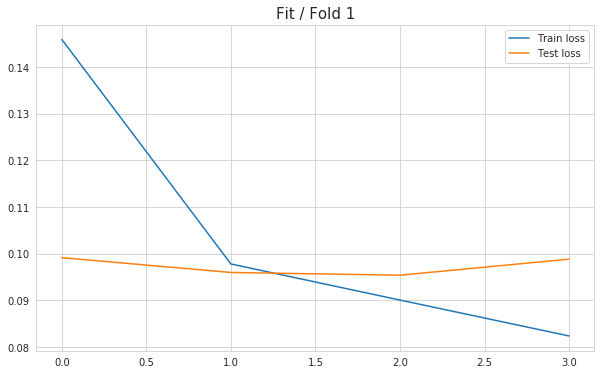

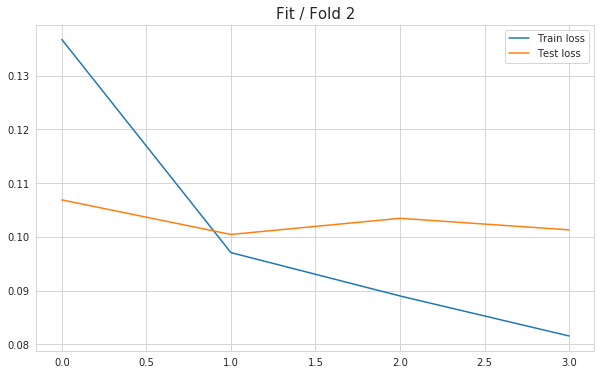

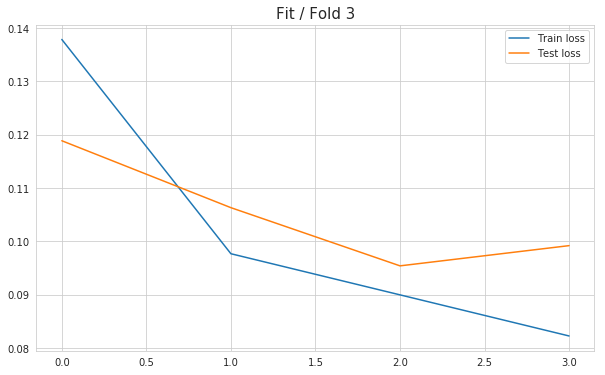

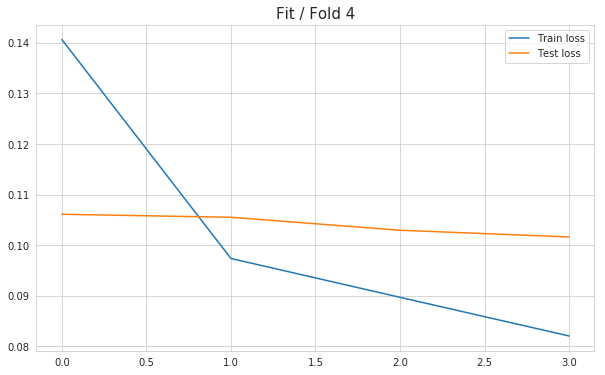

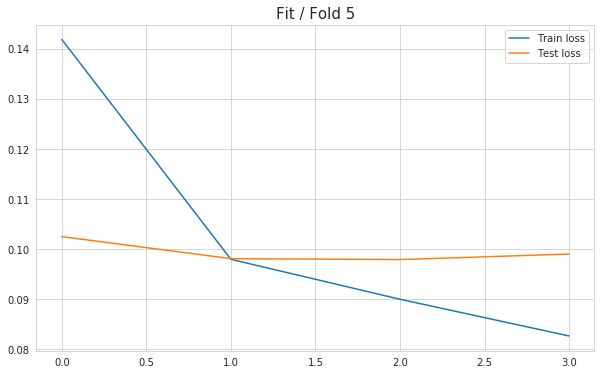

In [87]:
for i in range(len(histories)):
    plot_history(histories[i], "Fit / Fold " + str(i+1))

## Test prediction

In [88]:
coefs = [1/len(pred_tests)] * len(pred_tests)
pred_test =  np.sum(np.array([coefs[i] * pred_tests[i] for i in range(len(pred_tests))]), axis=0)

In [89]:
threshold2 = np.mean(thresholds)  #Or take cv threshold ?
print(threshold2)

0.32399999999999995


In [90]:
label_test = (pred_test > threshold).astype(int)

### Submission

In [91]:
output = pd.DataFrame({"qid": test_df["qid"].values})
output['prediction'] = label_test
output.to_csv("submission.csv", index=False)

In [92]:
output.head()

,qid,prediction
0,00014894849d00ba98a9,0
1,000156468431f09b3cae,0
2,000227734433360e1aae,0
3,0005e06fbe3045bd2a92,0
4,00068a0f7f41f50fc399,0


In [93]:
print(f"Ended in {(time.time() - begin) / 60 :.1f} minutes")

Ended in 102.2 minutes
